In [1]:
import sys
sys.path.append('/home/franzihe/Documents/Python/Thesis/')

import numpy as np
np.warnings.filterwarnings('ignore')
import createFolder as cF


import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


from windrose import WindroseAxes
import seaborn as sns
import matplotlib as mpl
from scipy.stats import linregress
from scipy import integrate

In [2]:
m = ['11', '12', '01', '02',]
station = 'Haukeliseter'
analysis_time =  '12' #'00'

#nc_dir = '/home/franzihe/Documents/Data/Weathermast_MEPS_Retrieval/'  #direction to save the final file

In [3]:
# plot cosmetics
sns.set_context('paper', font_scale=1.6)

sns.set(font = 'Serif', font_scale = 1.6, )
sns.set_style('ticks', 
                  {'font.family':'serif', #'font.serif':'Helvetica'
                   'grid.linestyle': '--',
                   'axes.grid': True,
                  }, 
                   )
# Set the palette to the "pastel" default palette:
sns.set_palette("colorblind")

In [4]:
savefig = 0
if savefig == 1:
    figdir = '/home/franzihe/Documents/Figures/Weathermast_MEPS_Retrieval/%s/MEPS_CTRL_ICET/' %(station)
    # figdir = '/home/franzihe/Documents/Figures/Weathermast_MEPS_Retrieval/%s/MEPS_CTRL_ICET_4gp/' %(station)
    cF.createFolder('%s/' %figdir)
    form = 'png'

In [5]:
obs_double_fence_acc_mean = dict()
obs_wind_dir_10m          = dict()
obs_wind_speed_10m        = dict()
obs_dofe_temp             = dict()



obs_westerly_idx = dict()
obs_easterly_idx = dict()

obs_westerly = dict()
obs_easterly = dict()

obs_diff      = dict()
obs_diff_2deg = dict()
obs_diff_2deg_west = dict()
obs_diff_2deg_east = dict()

obs = dict()

In [6]:
ret_diff_pulsed = dict()
ret_diff_upslope = dict()
swc_pulsed = dict()
swc_upslope = dict()

ret_diff_2deg = dict()
SWC = dict()
ret_diff_2deg_west = dict()
ret_diff_2deg_east = dict()

ret = dict()

In [7]:
meps_run = ['MEPS', 'CTRL', 'ICE-T', ]
#meps_run = np.arange(0,10).astype('<U21')
#meps_run = np.hstack((np.arange(0,10), ['CTRL', 'ICE-T']))

meps_precip_acc = dict()
meps_xwind_10m = dict()
meps_ywind_10m = dict()
meps_temp      = dict()

meps_diff = dict()
meps_diff_2deg = dict()
meps_diff_2deg_west = dict()
meps_diff_2deg_east = dict()
meps_wind_dir = dict()
meps_wind_speed = dict()

meps_westerly = dict()
meps_easterly = dict()
meps_SWC = dict()
meps_SWP = dict()

meps = dict()

In [8]:
eklima_diff = dict()
eklima_wind_dir_10m = dict()
eklima_wind_speed_10m = dict()
eklima_dofe_temp = dict()


eklima_westerly = dict()
eklima_easterly = dict()

eklima_diff_2deg = dict()

In [9]:
def wind_assignment_lower_10min(obs_westerly_idx, obs_easterly_idx):
        sub_idx = []   # locates the ending of the westerly burst
        for i in range(obs_westerly_idx.shape[0] -1):
            if obs_westerly_idx[i] + 1  == obs_westerly_idx[i+1]:
                continue
            else:
                sub_idx.append(i)
        sub_idx = np.asarray(sub_idx)
        
        _ww = []
        ## find westerlies which are < 10 min and assign them to obs_easterly wind regime
        if len(obs_westerly_idx) == 0 and len(sub_idx) == 0: # if there are only easterlies create empty westerly array
            obs_westerly = pd.DataFrame()
            
            if len(obs_easterly_idx) == 0:
                obs_easterly =  pd.DataFrame()
            else:
                obs_easterly = pd.DataFrame(obs_easterly_idx[:])

        elif len(obs_westerly_idx) != 0 and len(sub_idx) == 0:
            _ww = []
            obs_westerly = pd.DataFrame()
            
            if len(obs_easterly_idx) == 0:
                obs_easterly = pd.DataFrame()
            else:
                obs_easterly = pd.DataFrame(obs_easterly_idx[:])
            _west_duration = obs_westerly_idx[-1] - obs_westerly_idx[0]
            
            _ww.append(_west_duration)
            if _west_duration >= 10:  # adjusted from 28 to 10, becuase we only look at the lower 300 m with an assumed fallspeed of 1m/s and have a buffer we choose 10 min (without buffer 5min)
                obs_westerly = pd.concat([obs_westerly,
                                          pd.DataFrame(obs_westerly_idx[:])])
            elif _west_duration < 9: # adjusted from 28 to 10
                obs_easterly = pd.concat([obs_easterly,
                                          pd.DataFrame(obs_westerly_idx[:])])

        elif len(obs_westerly_idx) != 0 and len(sub_idx) !=0:
            obs_westerly = pd.DataFrame()#obs_westerly_idx)
            obs_easterly = pd.DataFrame(obs_easterly_idx)
            _ww = []
            for i in range(sub_idx.shape[0]+1):
                # calculate the durations,
                if i == 0:
                    _west_duration = obs_westerly_idx[sub_idx[i]] - \
                                     obs_westerly_idx[i]  # when at the beginning take the first sub index which locates the end of the westerly burst
                elif i == sub_idx.shape[0]:
                    _west_duration = obs_westerly_idx[-1] - \
                                     obs_westerly_idx[sub_idx[-1]+1] # when at the end take the last starting point of the westerly burst and subtract it from the last entry in the idx
                else:
                    _west_duration = obs_westerly_idx[sub_idx[i]] - \
                                     obs_westerly_idx[sub_idx[i-1]+1]  # any other time, take the ending of the westerly burst and subtract the starting of the westerly burst
                _ww.append(_west_duration)
 #               print(Date,'west duration', _west_duration, 'sub_idx', sub_idx, 'append', _ww)
                if _west_duration >= 10:
                    if i == 0:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[i : sub_idx[0]+1])])
#                        print(Date, 'obs_westerly', obs_westerly_idx[i : sub_idx[0]+1])
                    elif i == sub_idx.shape[0]:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[sub_idx.shape[0]-1]+1:])])
                    else:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[i-1]+1 : sub_idx[i]+1])])
                    
                elif _west_duration < 10:
 #                   print(Date,'west duration', _west_duration, sub_idx)
                    if i == 0:
                        obs_easterly = pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[i : sub_idx[i]+1])])
                    elif i == sub_idx.shape[0]:
                        obs_easterly =  pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[sub_idx.shape[0]-1]+1:])])
                    else:
                        obs_easterly = pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[i-1]+1 : sub_idx[i]+1])])

                
                
 #       print(_ww)  
        if len(obs_westerly) != 0:
            obs_westerly = obs_westerly.sort_values(0, axis = 0, ascending = True, ignore_index = True)
        elif len(obs_easterly) != 0:
            obs_easterly = obs_easterly.sort_values(0, axis = 0, ascending = True, ignore_index = True)

        return(obs_westerly, obs_easterly)

In [10]:
def read_meps_data(meps, station, Date):
                    # read in MEPS 
                    if meps == 'CTRL' or meps == 'ICE-T':
                        #meps_dirnc = '/home/franzihe/Documents/Data/MEPS/%s/%s/%s_00.nc' %(station,meps,Date)
                        meps_dirnc = '/home/franzihe/Documents/Data/MEPS/%s/%s_4gp/%s_00.nc' %(station,meps,Date)
                    elif meps == 'MEPS' :
                        #meps_dirnc = '/home/franzihe/Documents/Data/MEPS/%s/%s/sfc_hybrid5_allEM_00/%s_00.nc' %(station,str(Date)[:6],Date)
                        meps_dirnc = '/home/franzihe/Documents/Data/MEPS/%s/%s_4gp/sfc_hybrid5_allEM_00/%s_00.nc' %(station,str(Date)[:6],Date)
  #                  try:
                    meps_f = xr.open_dataset(meps_dirnc)
 #                   except OSError:
#                        print('no MEPS file found {:}: {:}'.format(meps,Date))
                    if meps == 'CTRL' or meps == 'ICE-T':
                        meps_precip_acc  = meps_f.precipitation_amount_acc[12:36,0,]
                        meps_xwind_10m  = meps_f.x_wind_10m[12:36,0,]
                        meps_ywind_10m  = meps_f.y_wind_10m[12:36,0,]
                        meps_temp  = (meps_f.air_temperature_2m[12:36,0,] - 273.15)
                        
                        ice = meps_f.atmosphere_cloud_ice_content_ml[12:36,:,]
                        snow = meps_f.atmosphere_cloud_snow_content_ml[12:36,:,]
                        graupel = meps_f.atmosphere_cloud_graupel_content_ml[12:36,:,]
                        pressure_ml = meps_f.pressure_ml[12:36,:,]
                        air_temperature_ml = meps_f.air_temperature_ml[12:36,:,]
                        layer_thickness = meps_f.layer_thickness[12:36,:,]

                        # get ice amount (snow+grauple+cloud ice)
                        ice_amount_ml = ice + snow + graupel
                        # calculate density at each level
                        density_ml = pressure_ml / (287*air_temperature_ml)
                        # convert from [kg/kg] to [kg/m^3]
                        ice_amount_ml = ice_amount_ml * density_ml
                        # convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
                        ice_amount_ml = ice_amount_ml *1000.

                        # layer thickness to calculate height
                        h_above = []
                        h_above.append(np.zeros(layer_thickness.shape[0]))
                        th_arr = np.nansum([np.array(h_above)[0,:],
                                            layer_thickness[:,0]], axis = 0)
                        h_above.append(th_arr)
                        for i in range(2, layer_thickness.shape[1]+1):
                            th_arr = np.nansum([np.asarray(h_above)[i-1,:],
                                                layer_thickness[:,i-1]], axis = 0)
                            h_above.append(th_arr)
                        height_ml = np.asarray(h_above)

                        # get SWC from MEPS at the same altitude as from the Retrieval
                        height_SWC = np.arange(400, 3200, 200)
                        height_meps = np.empty(shape = (height_ml.shape[1], 14))
                        height_meps[:] = np.nan

                        SWC_meps = np.empty(shape = (height_ml.shape[1], 14))
                        SWC_meps[:] = np.nan
                        for i in range(height_ml.shape[1]):
                            for k in range(14):
                                _idx = np.abs(np.transpose(height_ml)[i,:] - height_SWC[k]).argmin()

                                height_meps[i,k] = np.transpose(height_ml)[i,_idx]
                                SWC_meps[i,k] = ice_amount_ml[i, _idx]

                        # calculate the snow water path
                        SWP_meps = integrate.simps(SWC_meps, height_meps)

                        SWC_meps = pd.DataFrame(SWC_meps)
                        SWP_meps = pd.DataFrame(SWP_meps)
                    
                    if meps == 'MEPS':
                        meps_precip_acc  = meps_f.precipitation_amount_acc[12:36,0,:].mean(dim = 'ensemble_member')
                        meps_xwind_10m  = meps_f.x_wind_10m[12:36,0,:].mean(dim = 'ensemble_member')
                        meps_ywind_10m  = meps_f.y_wind_10m[12:36,0,:].mean(dim = 'ensemble_member')
                        meps_temp  = (meps_f.air_temperature_2m[12:36,0,:] - 273.15).mean(dim = 'ensemble_member')
                        SWC_meps = pd.DataFrame()
                        SWP_meps = pd.DataFrame()
                    # calculate the precipitation difference since it is accumulated
                    meps_diff     = np.empty(shape = meps_precip_acc.shape)
                    meps_diff [:] = np.nan

                    for i in range(meps_precip_acc.shape[0]-1):
                        meps_diff[int(i), ] = meps_precip_acc[int(i)+1, ] - \
                                                     meps_precip_acc[int(i), ]

                    # calculate the wind direction and speed from x and y wind
                    meps_wind_dir  = xr.ufuncs.arctan2(meps_ywind_10m , meps_xwind_10m ).rename('wind_dir')
                    meps_wind_dir  = (270 - xr.ufuncs.rad2deg(meps_wind_dir )).values

                    _larger360 = np.where(meps_wind_dir[:,] > 360.)
                    meps_wind_dir[_larger360] = meps_wind_dir[_larger360] - 360.

                    meps_wind_speed = xr.ufuncs.sqrt(meps_xwind_10m**2 + meps_ywind_10m**2).rename('wind_speed')

                    # Find wind regimes and associated precip amount
                    IDX = np.arange(meps_wind_dir.shape[0])
    
                    ## find all obs_westerly regimes (202.5 - 22.5 deg)
                    meps_westerly = IDX[np.logical_or(np.logical_and(meps_wind_dir[:,] >= 202.5 ,
                                                                               meps_wind_dir[:,] <= 360.),
                                                meps_wind_dir[:,] < 22.5)]

                    if len(meps_westerly  != 0):
                        meps_westerly  = pd.DataFrame(meps_westerly ).rename(columns = {0:'westerly_idx'})
                    else:
                        meps_westerly  = pd.DataFrame()


                    ## find all obs_easterly regimes (22.5 - 202.5 deg)
                    meps_easterly = IDX[np.logical_and(meps_wind_dir[:,] >= 22.5,
                                                                meps_wind_dir[:,] < 202.5)]
                    if len(meps_easterly != 0):
                        meps_easterly = pd.DataFrame(meps_easterly).rename(columns = {0:'easterly_idx'})

                    else:
                        meps_easterly = pd.DataFrame()

 

                   #### assign nan values where air temperature is larger than 2 degC
                    meps_diff_2deg = pd.DataFrame(meps_diff)

                    filter = meps_temp.to_dataframe()['air_temperature_2m'] < 2.
                    meps_diff_2deg.where(filter, inplace = True, other = np.nan)
                
                    #### write westerly and easterly precip to own array
                    meps_diff_2deg_west = np.empty(shape = len(meps_westerly) + len(meps_easterly))
                    meps_diff_2deg_west[:] = np.nan
                    if len(meps_westerly) != 0:
                        meps_diff_2deg_west[np.asarray(meps_westerly['westerly_idx'])] = meps_diff_2deg[0][np.asarray(meps_westerly['westerly_idx'])]

                    meps_diff_2deg_east = np.empty(shape = len(meps_westerly) + len(meps_easterly))
                    meps_diff_2deg_east[:] = np.nan
                    if len(meps_easterly) != 0:
                        meps_diff_2deg_east[np.asarray(meps_easterly['easterly_idx'])] = meps_diff_2deg[0][np.asarray(meps_easterly['easterly_idx'])]

                        
                    meps_f.close()
                    
                    meps_wind_dir = pd.DataFrame(meps_wind_dir)
                    meps_wind_speed = meps_wind_speed.to_dataframe()['wind_speed']
                    meps_temp =  meps_temp.to_dataframe()['air_temperature_2m']
                    
                    return(meps_wind_dir, meps_wind_speed, meps_diff_2deg,
                           meps_diff_2deg_west, meps_diff_2deg_east,
                           meps_temp, meps_westerly, meps_easterly, SWC_meps, SWP_meps)

In [11]:
date = []
for month in m:
    if month == '11':
        t = np.arange(29,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        Date = int(year+month+day)


        ## Minuelty observations
        obs_dirnc = '/home/franzihe/Documents/Data/Weathermast/%s/CTRL_ICE-T/Met_%s_%s_%s.nc' %(station,Date,analysis_time,station)
        obs_f = xr.open_dataset(obs_dirnc)
        obs_f = obs_f.assign_coords(time = np.arange(0,1440), accum = np.arange(0,3))

        obs_double_fence_acc_mean[Date] = obs_f.double_fence_accum.mean(axis = 1, skipna = True)
        obs_wind_dir_10m[Date]   = obs_f['10m_wind_dir_mast1']
        obs_wind_speed_10m[Date] = obs_f['10m_wind_speed_mast1']
        obs_dofe_temp[Date]      = obs_f['air_temp']


        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        obs_diff[Date]    = np.empty(shape = obs_double_fence_acc_mean[Date].shape)
        obs_diff[Date][:] = np.nan

        for i in range(obs_double_fence_acc_mean[Date].shape[0]-1):
                obs_diff[Date][int(i),] = obs_double_fence_acc_mean[Date][int(i)+1] - \
                                          obs_double_fence_acc_mean[Date][int(i)]

        # Find wind regimes and associated precip amount
        IDX = np.arange(obs_double_fence_acc_mean[Date].shape[0])

        ## find all obs_westerly regimes (202.5 - 22.5 deg)
        obs_westerly_idx[Date] = IDX[np.logical_or(np.logical_and(obs_wind_dir_10m[Date][:,] >= 202.5 ,
                                                                  obs_wind_dir_10m[Date][:,] <= 360.),
                                    obs_wind_dir_10m[Date][:,] < 22.5)]

        ## find all obs_easterly regimes (22.5 - 202.5 deg)
        obs_easterly_idx[Date] = IDX[np.logical_and(obs_wind_dir_10m[Date][:,] >= 22.5,
                                                    obs_wind_dir_10m[Date][:,] < 202.5)]


        

        # find when westerly is < 10 min within an easterly wind and assign it to easterly
        obs_westerly[Date], obs_easterly[Date]  = wind_assignment_lower_10min(obs_westerly_idx[Date], 
                                                                              obs_easterly_idx[Date])

        
        
        
        if len(obs_easterly[Date]) == 0 or len(obs_westerly[Date]) == 0:
            print(Date, 'only one direction')
            

        else:
            obs_westerly[Date] = obs_westerly[Date].sort_values(0, axis = 0, ascending = True, ignore_index = True)
            obs_easterly[Date] = obs_easterly[Date].sort_values(0, axis = 0, ascending = True, ignore_index = True)
            # find when easterly is < 10 min within a westerly wind and assign it to westerly
            obs_easterly[Date], obs_westerly[Date]  = wind_assignment_lower_10min(obs_easterly[Date][0].to_numpy(), 
                                                                              obs_westerly[Date][0].to_numpy(), )
        if len(obs_westerly[Date]) != 0:
                obs_westerly[Date] = obs_westerly[Date].sort_values(0, axis = 0, ascending = True, ignore_index = True)
                obs_westerly[Date] = obs_westerly[Date].rename(columns = {0:'westerly_idx'},)
                obs_westerly[Date] = obs_westerly[Date].astype('int64')
        if len(obs_easterly[Date]) != 0:
                obs_easterly[Date] = obs_easterly[Date].sort_values(0, axis = 0, ascending = True, ignore_index = True)
                obs_easterly[Date] = obs_easterly[Date].rename(columns = {0:'easterly_idx'}, )
                obs_easterly[Date] = obs_easterly[Date].astype('int64')
        
        
        #### assign nan values where air temperature is larger than 2 degC
        obs_diff_2deg[Date] = pd.DataFrame(obs_diff[Date])
        filter = obs_dofe_temp[Date].to_dataframe()['air_temp'] <= 2.
        obs_diff_2deg[Date].where(filter,inplace = True, other = np.nan)
        obs_diff_2deg[Date].rename(columns = {0:'precip_diff_2deg'}, inplace = True)

        
        
        obs_f.close()
        # Retrieval data: assign OESR depending on the wind direction

        ret_dirnc = '/home/franzihe/Documents/Data/Retrieval/%s/minute_surface_acc/CTRL_ICE-T/%s_%s.nc' %(station,Date,analysis_time)
        
        try:
            ret_f = xr.open_dataset(ret_dirnc)
        except OSError:
            print(Date, 'no retrieval data')

        else:
            ret_f = ret_f.assign_coords(time = np.arange(0,1440), )
            ret_diff_pulsed[Date] = ret_f['pulsed_sfc_acc']
            ret_diff_upslope[Date] = ret_f['upslope_sfc_acc']
            swc_pulsed[Date] = ret_f['pulsed_SWC']
            swc_upslope[Date] = ret_f['upslope_SWC']

            if len(obs_westerly[Date]) ==  len(ret_diff_pulsed[Date]): #only westerlies, use retrieval for westerlies
                ret_diff_2deg[Date] = ret_diff_pulsed[Date].to_dataframe()
                ret_diff_2deg[Date] = ret_diff_2deg[Date].rename(columns = {'pulsed_sfc_acc':'precip_diff_2deg'})
                
                
                ret_diff_2deg_west[Date] = ret_diff_pulsed[Date].to_dataframe()
                ret_diff_2deg_west[Date] = ret_diff_2deg_west[Date].rename(columns = {'pulsed_sfc_acc':'precip_diff_2deg'})
                
                obs_diff_2deg_west[Date] = obs_diff_2deg[Date][:]
                
                ret_diff_2deg_east[Date] = np.empty(shape = 1440)
                ret_diff_2deg_east[Date][:] =  np.nan
                ret_diff_2deg_east[Date] =  pd.DataFrame(ret_diff_2deg_east[Date])
                
                obs_diff_2deg_east[Date] = np.empty(shape = 1440)
                obs_diff_2deg_east[Date][:] = np.nan
                obs_diff_2deg_east[Date] = pd.DataFrame(obs_diff_2deg_east[Date])
                
                SWC[Date] = np.empty(shape = (len(obs_westerly[Date]) + len(obs_easterly[Date]), 14))
                SWC[Date][:] = np.nan
                SWC[Date][:] =  swc_pulsed[Date].values[:]
                SWC[Date] = pd.DataFrame(SWC[Date])
            elif len(obs_easterly[Date]) == len(ret_diff_upslope[Date]): #only easterlies, use retrieval for easterlies
                ret_diff_2deg[Date] = ret_diff_upslope[Date].to_dataframe()
                ret_diff_2deg[Date] = ret_diff_2deg[Date].rename(columns = {'upslope_sfc_acc':'precip_diff_2deg'})
                
                ret_diff_2deg_east[Date] = ret_diff_upslope[Date].to_dataframe()
                ret_diff_2deg_east[Date] = ret_diff_2deg_east[Date].rename(columns = {'upslope_sfc_acc':'precip_diff_2deg'})
                
                obs_diff_2deg_east[Date] = obs_diff_2deg[Date][:]
                
                ret_diff_2deg_west[Date] = np.empty(shape = 1440)
                ret_diff_2deg_west[Date][:] =  np.nan
                ret_diff_2deg_west[Date] = pd.DataFrame(ret_diff_2deg_west[Date])
                
                
                obs_diff_2deg_west[Date] = np.empty(shape = 1440)
                obs_diff_2deg_west[Date][:] =  np.nan
                obs_diff_2deg_west[Date] = pd.DataFrame(obs_diff_2deg_west[Date])
                
                SWC[Date] = np.empty(shape = (len(obs_westerly[Date]) + len(obs_easterly[Date]), 14))
                SWC[Date][:] = np.nan
                SWC[Date][:] = swc_upslope[Date].values[:]
                SWC[Date] = pd.DataFrame(SWC[Date])

            elif len(obs_westerly[Date]) + len(obs_easterly[Date]) == len(ret_diff_pulsed[Date]) and \
                 len(obs_westerly[Date]) + len(obs_easterly[Date]) == len(ret_diff_upslope[Date]): #both wind directions exist
                ret_diff_2deg[Date] = np.empty(shape = len(obs_westerly[Date]) + len(obs_easterly[Date]))
                ret_diff_2deg[Date][:] = np.nan
                ret_diff_2deg[Date][np.asarray(obs_westerly[Date]['westerly_idx'])] = ret_diff_pulsed[Date][np.asarray(obs_westerly[Date]['westerly_idx'])]
                ret_diff_2deg[Date][np.asarray(obs_easterly[Date]['easterly_idx'])] = ret_diff_upslope[Date][np.asarray(obs_easterly[Date]['easterly_idx'])]
                ret_diff_2deg[Date] = pd.DataFrame(ret_diff_2deg[Date])
                
                ret_diff_2deg_west[Date] = np.empty(shape = len(obs_westerly[Date]) + len(obs_easterly[Date]))
                ret_diff_2deg_west[Date][:] = np.nan
                ret_diff_2deg_west[Date][np.asarray(obs_westerly[Date]['westerly_idx'])] = ret_diff_pulsed[Date][np.asarray(obs_westerly[Date]['westerly_idx'])]
                ret_diff_2deg_west[Date] = pd.DataFrame(ret_diff_2deg_west[Date])
                
                obs_diff_2deg_west[Date] = np.empty(shape = len(obs_westerly[Date]) + len(obs_easterly[Date]))
                obs_diff_2deg_west[Date][:] = np.nan
                obs_diff_2deg_west[Date][np.asarray(obs_westerly[Date]['westerly_idx'])] = obs_diff_2deg[Date]['precip_diff_2deg'][np.asarray(obs_westerly[Date]['westerly_idx'])]
                obs_diff_2deg_west[Date] = pd.DataFrame(obs_diff_2deg_west[Date])

                ret_diff_2deg_east[Date] = np.empty(shape = len(obs_westerly[Date]) + len(obs_easterly[Date]))
                ret_diff_2deg_east[Date][:] = np.nan
                ret_diff_2deg_east[Date][np.asarray(obs_easterly[Date]['easterly_idx'])] = ret_diff_upslope[Date][np.asarray(obs_easterly[Date]['easterly_idx'])]
                ret_diff_2deg_east[Date] = pd.DataFrame(ret_diff_2deg_east[Date])
                
                obs_diff_2deg_east[Date] = np.empty(shape = len(obs_westerly[Date]) +  len(obs_easterly[Date]))
                obs_diff_2deg_east[Date][:] = np.nan
                obs_diff_2deg_east[Date][np.asarray(obs_easterly[Date]['easterly_idx'])] = obs_diff_2deg[Date]['precip_diff_2deg'][np.asarray(obs_easterly[Date]['easterly_idx'])]
                obs_diff_2deg_east[Date] = pd.DataFrame(obs_diff_2deg_east[Date])
                
                if ret_diff_2deg[Date].columns == 'pulsed_sfc_acc':
                    ret_diff_2deg[Date].rename(columns = {'pulsed_sfc_acc':'precip_diff_2deg'}, inplace = True)
                if ret_diff_2deg[Date].columns == 'upslope_sfc_acc':
                    ret_diff_2deg[Date].rename(columns = {'upslope_sfc_acc':'precip_diff_2deg'}, inplace = True)
                if ret_diff_2deg[Date].columns == 0:
                    ret_diff_2deg[Date].rename(columns = {0:'precip_diff_2deg'}, inplace = True)
                

                SWC[Date] = np.empty(shape = (len(obs_westerly[Date]) + len(obs_easterly[Date]), 14))
                SWC[Date][:] = np.nan
                SWC[Date][np.asarray(obs_westerly[Date]['westerly_idx'])] = swc_pulsed[Date][np.asarray(obs_westerly[Date]['westerly_idx'])].values
                SWC[Date][np.asarray(obs_easterly[Date]['easterly_idx'])] = swc_upslope[Date][np.asarray(obs_easterly[Date]['easterly_idx'])].values
                SWC[Date] = pd.DataFrame(SWC[Date])
            ret_f.close()    
            
            if len(obs_westerly[Date]) + len(obs_easterly[Date]) == 1440:
                if obs_diff_2deg[Date].sum()['precip_diff_2deg'] >= 0.25 and ret_diff_2deg[Date].sum()['precip_diff_2deg'] >= 0.25 :
                    print(Date)
                    date.append(Date)
                    
                    
                    

20161129 only one direction
20161129
20161130 only one direction
20161201 only one direction
20161202 only one direction
20161203 only one direction
20161204 only one direction
20161208 only one direction
20161208
20161209
20161210 only one direction
20161210
20161212
20161215
20161216 no retrieval data
20161217 no retrieval data
20161218 no retrieval data
20161220 only one direction
20161220
20161221
20161222
20161223
20161224 only one direction
20161224
20161225 only one direction
20161225
20161226 only one direction
20161226
20161229
20161230 only one direction
20161231 only one direction
20161231
20170102
20170103 only one direction
20170103
20170105
20170106
20170108
20170109 only one direction
20170109
20170110
20170111 only one direction
20170111
20170112
20170118 only one direction
20170119 only one direction
20170122 only one direction
20170124 only one direction
20170128
20170129 no retrieval data
20170130 no retrieval data
20170131 no retrieval data
20170201 only one directi

In [12]:
_hour = []
for Date in date[1:]:
#    print(Date)
    _in_hour = pd.DataFrame()
    for i in range(0, len(obs_wind_dir_10m[Date])+60, 60):
    #    print(i, i+60)
        _filter = np.logical_or(np.logical_and(obs_wind_dir_10m[Date][i:i+60,] >= 202.5 ,
                                               obs_wind_dir_10m[Date][i:i+60,] <= 360.),
                                obs_wind_dir_10m[Date][i:i+60,] < 22.5)
        _filter2 = np.logical_and(obs_wind_dir_10m[Date][i:i+60,] >= 22.5,
                                  obs_wind_dir_10m[Date][i:i+60,] < 202.5)
        if len(obs_wind_dir_10m[Date][i:i+60][_filter]) >= 10 and len(obs_wind_dir_10m[Date][i:i+60][_filter]) < 60:
            if len(obs_wind_dir_10m[Date][i:i+60][_filter2]) >= 10:
 #               print('{:}:{:}'.format(i, i+60), 'length westerly:', len(obs_wind_dir_10m[Date][i:i+60][_filter]), 
  #                       'length easterly:', len(obs_wind_dir_10m[Date][i:i+60][_filter2]))
                _hour.append([i, i+60, len(obs_wind_dir_10m[Date][i:i+60][_filter]), 1, len(obs_wind_dir_10m[Date][i:i+60][_filter2]), 1])

In [13]:
pd.DataFrame(_hour)[3].sum(), len(date[1:])*len(obs_wind_dir_10m[Date])/60, pd.DataFrame(_hour)[3].sum()/(len(date[1:])*len(obs_wind_dir_10m[Date])/60)*100

(97, 648.0, 14.969135802469136)

In [14]:
for Date in date[1:]:
    
    fig, axs = plt.subplots(1, 1, figsize = [14,7])
    #obs_wind_dir_10m[Date]
    obs_wind_dir_10m[Date][np.logical_or(np.logical_and(obs_wind_dir_10m[Date][:,] >= 202.5 ,
                                                                      obs_wind_dir_10m[Date][:,] <= 360.),
                                        obs_wind_dir_10m[Date][:,] < 22.5)].plot(ax = axs, marker = '.', color = 'r')
    if len(obs_wind_dir_10m[Date][np.logical_or(np.logical_and(obs_wind_dir_10m[Date][:,] >= 202.5 ,
                                                                      obs_wind_dir_10m[Date][:,] <= 360.),
                                        obs_wind_dir_10m[Date][:,] < 22.5)]) != 1440:
        obs_wind_dir_10m[Date][np.logical_and(obs_wind_dir_10m[Date][:,] >= 22.5,
                                                        obs_wind_dir_10m[Date][:,] < 202.5)].plot(ax = axs, marker ='<', color = 'b')
    axs.set_xticks(np.arange(len(obs_wind_dir_10m[Date])+60, step = 30)[::2]);
    axs.set_xticklabels(np.arange(len(obs_wind_dir_10m[Date])+60, step = 30)[::2]);
    plt.hlines(202.5, 0, len(obs_wind_dir_10m[Date])+60, )
    plt.hlines(22.5, 0, len(obs_wind_dir_10m[Date])+60, );
    plt.close()

    if savefig == 1:
        fig_name = 'obs_winddir_10min_corr_%s.%s' %(Date,form)
        plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=False)
        print('plot saved: %s/%s' %(figdir,fig_name))
        plt.close()

In [15]:
obs = dict()
obs['WD'] = pd.DataFrame()
obs['WS'] = pd.DataFrame()
obs['precip'] = pd.DataFrame()
#obs['precip_west'] = pd.DataFrame()
#obs['precip_east'] =  pd.DataFrame()
obs['2T'] = pd.DataFrame()
#obs['westerly_idx'] = pd.DataFrame()
#obs['easterly_idx'] = pd.DataFrame()

In [16]:
for Date in date[1:]:
    obs['WD'] = pd.concat([obs['WD'], 
                           obs_wind_dir_10m[Date].to_dataframe().rename(columns = {'10m_wind_dir_mast1':Date})], axis = 1)
    
    obs['WS'] = pd.concat([obs['WS'],
                           obs_wind_speed_10m[Date].to_dataframe().rename(columns = {'10m_wind_speed_mast1':Date})], axis = 1)
    obs['precip'] = pd.concat([obs['precip'],
                           obs_diff_2deg[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
#    if obs_diff_2deg_west[Date].columns == 0:
 #       obs['precip_west'] = pd.concat([obs['precip_west'],
  #                                  obs_diff_2deg_west[Date].rename(columns = {0:Date})], axis = 1)
   # if obs_diff_2deg_west[Date].columns == 'precip_diff_2deg':
    #    obs['precip_west'] = pd.concat([obs['precip_west'],
     #                               obs_diff_2deg_west[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
#    if obs_diff_2deg_east[Date].columns == 0:
 #       obs['precip_east'] = pd.concat([obs['precip_east'],
  #                                  obs_diff_2deg_east[Date].rename(columns = {0:Date})], axis = 1)
   # if obs_diff_2deg_east[Date].columns == 'precip_diff_2deg':
    #    obs['precip_east'] = pd.concat([obs['precip_east'],
     #                               obs_diff_2deg_east[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
    
    
    obs['2T'] = pd.concat([obs['2T'],
                           obs_dofe_temp[Date].to_dataframe().rename(columns = {'air_temp':Date})], axis = 1)
#    if obs_westerly[Date].columns == 'westerly_idx':
 #       obs['westerly_idx'] = pd.concat([obs['westerly_idx'],
  #                                   obs_westerly[Date].rename(columns = {'westerly_idx': Date})], axis = 1)
   # if obs_westerly[Date].columns == 0:
    #    obs['westerly_idx'] = pd.concat([obs['westerly_idx'],
     #                                    obs_westerly[Date].rename(columns = {0: Date})], axis = 1)
#    if obs_easterly[Date].columns == 'easterly_idx':
 #       obs['easterly_idx'] = pd.concat([obs['easterly_idx'],
  #                                   obs_westerly[Date].rename(columns = {'easterly_idx': Date})], axis = 1)
   # if obs_easterly[Date].columns == 0:
    #    obs['easterly_idx'] = pd.concat([obs['easterly_idx'],
     #                                    obs_easterly[Date].rename(columns = {0: Date})], axis = 1)

In [17]:
ret['WD'] = pd.DataFrame()
ret['WS'] = pd.DataFrame()
ret['precip'] = pd.DataFrame()
#ret['precip_west'] = pd.DataFrame()
#ret['precip_east'] = pd.DataFrame()
ret['2T'] = pd.DataFrame()
#ret['westerly_idx'] = pd.DataFrame()
#ret['easterly_idx'] = pd.DataFrame()
ret['SWC'] = pd.DataFrame()
ret['SWC_hourly'] = pd.DataFrame()
ret['2T_2d'] = pd.DataFrame()
ret['WD_2d'] = pd.DataFrame()
ret['WS_2d'] = pd.DataFrame()

In [18]:
for Date in date[1:]:
    ret['WD'] = pd.concat([ret['WD'], 
                           obs_wind_dir_10m[Date].to_dataframe().rename(columns = {'10m_wind_dir_mast1':Date})], axis = 1)
    
    ret['WS'] = pd.concat([ret['WS'],
                           obs_wind_speed_10m[Date].to_dataframe().rename(columns = {'10m_wind_speed_mast1':Date})], axis = 1)
    
    
    ret['precip'] = pd.concat([ret['precip'],
                           ret_diff_2deg[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
#    if ret_diff_2deg_west[Date].columns == 0:
 #       ret['precip_west'] = pd.concat([ret['precip_west'],
  #                         ret_diff_2deg_west[Date].rename(columns = {0:Date})], axis = 1)
   # if ret_diff_2deg_west[Date].columns == 'precip_diff_2deg':
    #    ret['precip_west'] = pd.concat([ret['precip_west'],
     #                      ret_diff_2deg_west[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
#    if ret_diff_2deg_east[Date].columns == 0:
 #       ret['precip_east'] = pd.concat([ret['precip_east'],
  #                         ret_diff_2deg_east[Date].rename(columns = {0:Date})], axis = 1)
   # if ret_diff_2deg_east[Date].columns == 'precip_diff_2deg':
    #    ret['precip_east'] = pd.concat([ret['precip_east'],
     #                      ret_diff_2deg_east[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)


    
    ret['2T'] = pd.concat([ret['2T'],
                           obs_dofe_temp[Date].to_dataframe().rename(columns = {'air_temp':Date})], axis = 1)
#    if obs_westerly[Date].columns == 'westerly_idx':
 #       ret['westerly_idx'] = pd.concat([ret['westerly_idx'],
  #                                   obs_westerly[Date].rename(columns = {'westerly_idx': Date})], axis = 1)
   # if obs_westerly[Date].columns == 0:
    #    ret['westerly_idx'] = pd.concat([ret['westerly_idx'],
     #                                    obs_westerly[Date].rename(columns = {0: Date})], axis = 1)
#    if obs_easterly[Date].columns == 'easterly_idx':
 #       ret['easterly_idx'] = pd.concat([ret['easterly_idx'],
  #                                   obs_westerly[Date].rename(columns = {'easterly_idx': Date})], axis = 1)
   # if obs_easterly[Date].columns == 0:
    #    ret['easterly_idx'] = pd.concat([ret['easterly_idx'],
     #                                    obs_easterly[Date].rename(columns = {0: Date})], axis = 1)
    ret['SWC'] = pd.concat([ret['SWC'],
                            SWC[Date]], axis = 0)
    ret['SWC_hourly'] = pd.concat([ret['SWC_hourly'],
                                   SWC[Date][::60].reset_index(drop = True)], axis = 0)


    ret_temp_2d = pd.DataFrame(obs_dofe_temp[Date][::60].to_dataframe().values.repeat(SWC[Date][::60].shape[1]).reshape((SWC[Date][::60].shape[0], SWC[Date][::60].shape[1])))
    ret_wind_dir_2d = pd.DataFrame(obs_wind_dir_10m[Date][::60].to_dataframe().values.repeat(SWC[Date][::60].shape[1]).reshape((SWC[Date][::60].shape[0], SWC[Date][::60].shape[1])))
    ret_wind_speed_2d = pd.DataFrame(obs_wind_speed_10m[Date][::60].to_dataframe().values.repeat(SWC[Date][::60].shape[1]).reshape((SWC[Date][::60].shape[0], SWC[Date][::60].shape[1])))

    ret['2T_2d'] = pd.concat([ret['2T_2d'],
                              ret_temp_2d], axis = 0)
    ret['WD_2d'] = pd.concat([ret['WD_2d'],
                              ret_wind_dir_2d,], axis = 0)
    ret['WS_2d'] = pd.concat([ret['WS_2d'],
                              ret_wind_speed_2d], axis = 0) 


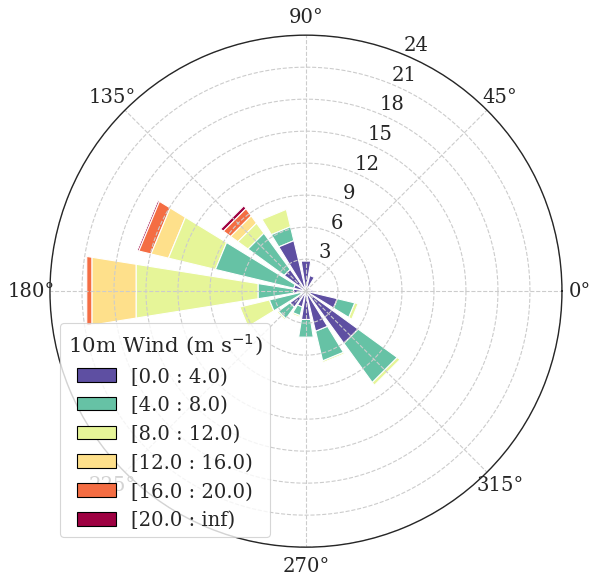

In [19]:
### Plot wind rose precipitation events

ax = WindroseAxes.from_ax()
ax.bar(obs['WD'][::60].where(obs['2T'][::60] < 2.).values.flatten(), 
       obs['WS'][::60].where(obs['2T'][::60] < 2.).values.flatten(),
       normed = True, opening = 0.8, edgecolor = 'white', cmap = plt.get_cmap('Spectral_r', 6),
       bins = np.arange(0,24,4))
ax._info['bins']
ax.set_legend()
ax.legend(title = '10m Wind (m s$^{-1}$)')
ax.set_yticks(np.arange(3,27, step = 3))
ax.set_yticklabels(np.arange(3, 27, step = 3));

if savefig == 1:
    fig_name = 'winter_2016_2017_windrose_obs.%s' %(form)
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' %(figdir,fig_name))
    plt.close()

In [20]:
# Plot 60 min accumulation DFAR vs OESR as a 2dhist

obs['WS_hourly'] = obs['WS'][::60].reset_index(drop=True)
ret['WS_hourly'] = ret['WS'][::60].reset_index(drop=True)

obs['WD_hourly'] = obs['WD'][::60].reset_index(drop=True)
ret['WD_hourly'] = ret['WD'][::60].reset_index(drop=True)

obs['2T_hourly'] = obs['2T'][::60].reset_index(drop=True)
ret['2T_hourly'] = ret['2T'][::60].reset_index(drop=True)


In [21]:
obs['precip_hourly'] = obs['precip'].groupby(obs['precip'].index // 60).sum()
ret['precip_hourly'] = ret['precip'].groupby(ret['precip'].index // 60).sum()


In [22]:
obs['precip_hourly'] = obs['precip_hourly'].where(obs['2T_hourly'] < 2.)

ret['precip_hourly'] = ret['precip_hourly'].where(obs['2T_hourly'] < 2.)


ret['SWC_hourly'] = ret['SWC_hourly'].where(ret['2T_2d'] < 2.)


In [23]:
obs['precip_west_hourly'] = obs['precip_hourly'].where(np.logical_or(np.logical_and(obs['WD_hourly'] >= 202.5 ,
                                                                                    obs['WD_hourly'] <= 360.),
                                                                     obs['WD_hourly'] < 22.5))
obs['precip_east_hourly'] = obs['precip_hourly'].where(np.logical_and(obs['WD_hourly'] >= 22.5,
                                                                      obs['WD_hourly'] < 202.5))

ret['precip_west_hourly'] = ret['precip_hourly'].where(np.logical_or(np.logical_and(ret['WD_hourly'] >= 202.5 ,
                                                                                    ret['WD_hourly'] <= 360.),
                                                                     ret['WD_hourly'] < 22.5))
ret['precip_east_hourly'] = ret['precip_hourly'].where(np.logical_and(ret['WD_hourly'] >= 22.5,
                                                                      ret['WD_hourly'] < 202.5))
ret['SWC_west_hourly'] = ret['SWC_hourly'].where(np.logical_or(np.logical_and(ret['WD_2d'] >= 202.5 ,
                                                                                    ret['WD_2d'] <= 360.),
                                                                     ret['WD_2d'] < 22.5))
ret['SWC_east_hourly'] = ret['SWC_hourly'].where(np.logical_and(ret['WD_2d'] >= 22.5,
                                                                      ret['WD_2d'] < 202.5))

In [24]:
obs['precip_west_hourly'] = obs['precip_west_hourly'].where(obs['2T_hourly'] < 2.)
obs['precip_east_hourly'] = obs['precip_east_hourly'].where(obs['2T_hourly'] < 2.)

ret['precip_west_hourly'] = ret['precip_west_hourly'].where(ret['2T_hourly'] < 2.)
ret['precip_east_hourly'] = ret['precip_east_hourly'].where(ret['2T_hourly'] < 2.)
ret['SWC_west_hourly'] = ret['SWC_west_hourly'].where(ret['2T_2d'] < 2.)
ret['SWC_east_hourly'] = ret['SWC_east_hourly'].where(ret['2T_2d'] < 2.)

In [25]:
def plt_2dhist_observation(axs, x, y,regime,  _range=None, vmax=None):
    cmap = plt.get_cmap('Spectral_r', 26)
    _mask = (~np.isnan(y) & ~np.isnan(x))

    counts, xedges, yedges, im = axs.hist2d(x[_mask],y[_mask], 
                                           bins = 20, 
                                          range = _range, 
                                           cmap = cmap,
                                           cmin=0.00000000001,
                                           norm = mpl.colors.Normalize(vmax = vmax)
                                           )
    
 #   _mask = (~np.isnan(y) & ~np.isnan(x))
    _x = np.linspace(0,5.1,20)
    _y = _x*linregress(x[_mask],y[_mask]).slope + linregress(x[_mask], y[_mask]).intercept
    
    axs.plot(_x, _y, 'r', linewidth = '2')

    
    annotation_string = r"""    {:}
    y = {:.2f}*x + {:.2f}
    R$^2$: {:.2f}
    """.format(regime,linregress(x[_mask],y[_mask]).slope, 
               linregress(x[_mask],y[_mask]).intercept, 
               linregress(x[_mask],y[_mask]).rvalue**2, )
#    print('counts',counts, 'sum',np.nansum(counts),'shape', counts.shape, np.nanmax(counts))
    return(annotation_string, im, )

In [26]:
fig_label = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)']

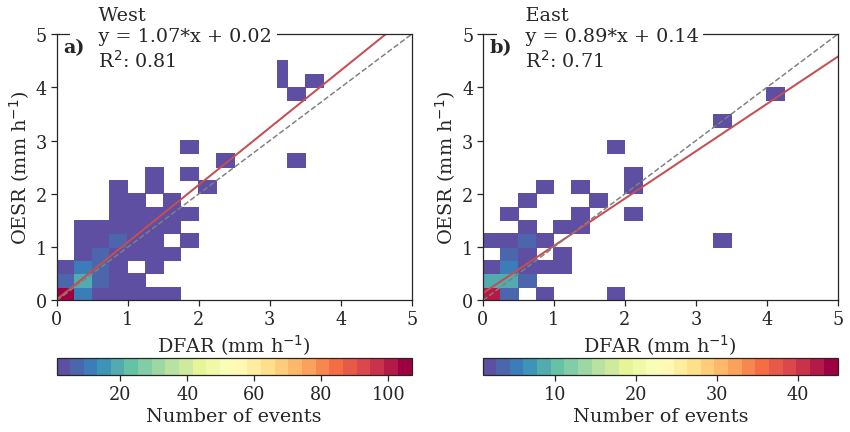

In [27]:
fig, axsm = plt.subplots(1, 2, figsize = [14,7])
axs = axsm.flatten()



annotation_string = dict()
# West
filter = np.logical_and(obs['precip_west_hourly'] != 0.,
               ret['precip_west_hourly'] != 0.)
annotation_string[0],im = plt_2dhist_observation(axs[0], 
                                      obs['precip_west_hourly'].where(filter, ).values,#.flatten(),
                                      ret['precip_west_hourly'].where(filter, ).values,#.flatten(), 
                                      'West',
                                        _range=[[0,5], [0,5]],
                                       vmax=107)
cbar = plt.colorbar(im, ax = axs[0], norm = mpl.colors.NoNorm, orientation = 'horizontal')
cbar.ax.set_xlabel('Number of events')

# East
filter = np.logical_and(obs['precip_east_hourly'] != 0.,
               ret['precip_east_hourly'] != 0.)
annotation_string[1],im = plt_2dhist_observation(axs[1], 
                                      obs['precip_east_hourly'].where(filter, ).values,#.flatten(),
                                      ret['precip_east_hourly'].where(filter, ).values,#.flatten(), 
                                      'East',
                                          _range=[[0,5], [0,5]],
                                       vmax=45
                                         )
cbar = plt.colorbar(im, ax = axs[1], norm = mpl.colors.NoNorm, orientation = 'horizontal')
cbar.ax.set_xlabel('Number of events')

for i in range(len(axs)):
#    axs[i].set_aspect('equal')
    axs[i].set_xlabel('DFAR (mm h$^{-1}$)')
    axs[i].set_ylabel('OESR (mm h$^{-1}$)')
    axs[i].plot([0,1], [0,1], transform = axs[i].transAxes, color = 'grey', ls = '--')
    axs[i].annotate(annotation_string[i], xy=(0.05, 0.80), xycoords='axes fraction',
                                             backgroundcolor='w', )
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    
    
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_2dhist_corr.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [28]:
## Create dictonary with dataframes of necessary varibles
# Sort seasonal accumulation in wind speed regime

for mr in meps_run:
    meps_wind_dir[mr] = dict()
    meps_wind_speed[mr] = dict()
    meps_diff_2deg[mr] = dict()
    meps_diff_2deg_west[mr] = dict()
    meps_diff_2deg_east[mr] = dict()
    meps_temp[mr] = dict()
    meps_westerly[mr] = dict()
    meps_easterly[mr] = dict()
    meps_SWC[mr] = dict()
    meps_SWP[mr] = dict()
    
    # create dataframe with all essential data
    meps[mr] = dict()
    meps[mr]['WD'] = pd.DataFrame()
    meps[mr]['WS'] = pd.DataFrame()
    meps[mr]['precip'] = pd.DataFrame()
    meps[mr]['precip_west'] = pd.DataFrame()
    meps[mr]['precip_east'] =  pd.DataFrame()
    meps[mr]['2T'] = pd.DataFrame()
    meps[mr]['westerly_idx'] = pd.DataFrame()
    meps[mr]['easterly_idx'] = pd.DataFrame()
    meps[mr]['SWC_hourly'] =  pd.DataFrame()
    meps[mr]['2T_2d'] = pd.DataFrame()
    meps[mr]['WD_2d'] = pd.DataFrame()
    meps[mr]['WS_2d'] = pd.DataFrame()
    
    for Date in date[1:]:
        meps_wind_dir[mr][Date], meps_wind_speed[mr][Date], \
        meps_diff_2deg[mr][Date], meps_diff_2deg_west[mr][Date], meps_diff_2deg_east[mr][Date], \
        meps_temp[mr][Date], meps_westerly[mr][Date], meps_easterly[mr][Date],\
        meps_SWC[mr][Date], meps_SWP[mr][Date] = read_meps_data(mr, station, Date)
                    


        meps[mr]['WD'] = pd.concat([meps[mr]['WD'], 
                               meps_wind_dir[mr][Date].rename(columns = {0:Date})], axis = 1)
        meps[mr]['WS'] = pd.concat([meps[mr]['WS'],
                                     pd.DataFrame(meps_wind_speed[mr][Date]).reset_index(drop = True).rename(columns = {'wind_speed':Date})],
                                    axis = 1)
        meps[mr]['precip'] = pd.concat([meps[mr]['precip'],
                                       meps_diff_2deg[mr][Date].rename(columns = {0:Date})], axis =1)

        meps[mr]['precip_west'] = pd.concat([meps[mr]['precip_west'],
                                        pd.DataFrame(meps_diff_2deg_west[mr][Date]).rename(columns = {0:Date})], axis = 1)
        meps[mr]['precip_east'] = pd.concat([meps[mr]['precip_east'],
                                        pd.DataFrame(meps_diff_2deg_east[mr][Date]).rename(columns = {0:Date})], axis = 1)
        meps[mr]['2T'] = pd.concat([meps[mr]['2T'],
                                    pd.DataFrame(meps_temp[mr][Date]).reset_index(drop = True).rename(columns = {'air_temperature_2m':Date})], axis =1 )
        meps[mr]['westerly_idx'] = pd.concat([meps[mr]['westerly_idx'],
                                              meps_westerly[mr][Date].rename(columns = {'westerly_idx':Date})], axis = 1)
        meps[mr]['easterly_idx'] = pd.concat([meps[mr]['easterly_idx'],
                                              meps_easterly[mr][Date].rename(columns = {'easterly_idx':Date})], axis = 1)
        if mr == 'CTRL'  or mr == 'ICE-T':
            meps[mr]['SWC_hourly'] = pd.concat([meps[mr]['SWC_hourly'],
                                   meps_SWC[mr][Date]], axis = 0)
            meps_temp_2d = pd.DataFrame(meps_temp[mr][Date].values.repeat(meps_SWC[mr][Date].shape[1],).reshape((meps_SWC[mr][Date].shape[0], meps_SWC[mr][Date].shape[1])))
            meps_wind_dir_2d = pd.DataFrame(meps_wind_dir[mr][Date].values.repeat(meps_SWC[mr][Date].shape[1],).reshape((meps_SWC[mr][Date].shape[0], meps_SWC[mr][Date].shape[1])))
            meps_wind_speed_2d = pd.DataFrame(meps_wind_speed[mr][Date].values.repeat(meps_SWC[mr][Date].shape[1],).reshape((meps_SWC[mr][Date].shape[0], meps_SWC[mr][Date].shape[1])))
            meps[mr]['2T_2d'] = pd.concat([meps[mr]['2T_2d'],
                                           meps_temp_2d], axis = 0)
            meps[mr]['WD_2d'] = pd.concat([meps[mr]['WD_2d'],
                                           meps_wind_dir_2d,], axis = 0)
            meps[mr]['WS_2d'] = pd.concat([meps[mr]['WS_2d'],
                                           meps_wind_speed_2d], axis = 0) 

            meps[mr]['SWC_hourly_west'] = meps[mr]['SWC_hourly'].where(np.logical_or(np.logical_and(meps[mr]['WD_2d'] >= 202.5 ,
                                                                      meps[mr]['WD_2d']<= 360.),
                                                       meps[mr]['WD_2d']< 22.5))

            meps[mr]['SWC_hourly_east'] = meps[mr]['SWC_hourly'].where(np.logical_and(meps[mr]['WD_2d'] >= 22.5,
                                                                                  meps[mr]['WD_2d'] < 202.5))

            


    
    meps[mr]['precip'] = meps[mr]['precip'].where(meps[mr]['2T'] < 2.)
    meps[mr]['precip_west'] = meps[mr]['precip_west'].where(meps[mr]['2T'] < 2.)
    meps[mr]['precip_east'] = meps[mr]['precip_east'].where(meps[mr]['2T'] < 2.)
    meps[mr]['SWC_hourly'] = meps[mr]['SWC_hourly'].where(meps[mr]['2T_2d'] < 2.)
    # West  
    meps[mr]['precip_west_hourly_0_4'] = meps[mr]['precip_west'].where(meps[mr]['WS'] < 4)
    meps[mr]['precip_west_hourly_4_8'] = meps[mr]['precip_west'].where(np.logical_and(meps[mr]['WS'] >= 4., meps[mr]['WS'] < 8.))
    meps[mr]['precip_west_hourly_8_12'] = meps[mr]['precip_west'].where(np.logical_and(meps[mr]['WS'] >= 8., meps[mr]['WS'] < 12.))
    meps[mr]['precip_west_hourly_12_16'] = meps[mr]['precip_west'].where(np.logical_and(meps[mr]['WS'] >= 12., meps[mr]['WS'] < 16.))
    meps[mr]['precip_west_hourly_16_20'] = meps[mr]['precip_west'].where(np.logical_and(meps[mr]['WS'] >= 16., meps[mr]['WS'] < 20.))
    meps[mr]['precip_west_hourly_20'] = meps[mr]['precip_west'].where(meps[mr]['WS'] >= 20.)
    
    
    meps[mr]['precip_west_ws'] = [meps[mr]['precip_west_hourly_0_4'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_hourly_4_8'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_hourly_8_12'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_hourly_12_16'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_hourly_16_20'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_hourly_20'].sum(axis=1, skipna= True).sum()]
    
    if mr == 'CTRL'  or mr == 'ICE-T':
        meps[mr]['SWC_hourly_west'] = meps[mr]['SWC_hourly_west'].where(meps[mr]['2T_2d'] < 2.)
        meps[mr]['SWC_west_hourly_0_4']  = meps[mr]['SWC_hourly_west'].where(meps[mr]['WS_2d'] < 4.)
        meps[mr]['SWC_west_hourly_4_8'] = meps[mr]['SWC_hourly_west'].where(np.logical_and(meps[mr]['WS_2d'] >= 4., meps[mr]['WS_2d'] < 8.))
        meps[mr]['SWC_west_hourly_8_12'] = meps[mr]['SWC_hourly_west'].where(np.logical_and(meps[mr]['WS_2d'] >= 8., meps[mr]['WS_2d'] < 12.))
        meps[mr]['SWC_west_hourly_12_16'] = meps[mr]['SWC_hourly_west'].where(np.logical_and(meps[mr]['WS_2d'] >= 12., meps[mr]['WS_2d'] < 16.))
        meps[mr]['SWC_west_hourly_16_20'] = meps[mr]['SWC_hourly_west'].where(np.logical_and(meps[mr]['WS_2d'] >= 16., meps[mr]['WS_2d'] < 20.))
        meps[mr]['SWC_west_hourly_20'] = meps[mr]['SWC_hourly_west'].where(meps[mr]['WS_2d'] >= 20.)

    
    # East
    meps[mr]['precip_east_hourly_0_4'] = meps[mr]['precip_east'].where(meps[mr]['WS'] < 4)
    meps[mr]['precip_east_hourly_4_8'] = meps[mr]['precip_east'].where(np.logical_and(meps[mr]['WS'] >= 4., meps[mr]['WS'] < 8.))
    meps[mr]['precip_east_hourly_8_12'] = meps[mr]['precip_east'].where(np.logical_and(meps[mr]['WS'] >= 8., meps[mr]['WS'] < 12.))
    meps[mr]['precip_east_hourly_12_16'] = meps[mr]['precip_east'].where(np.logical_and(meps[mr]['WS'] >= 12., meps[mr]['WS'] < 16.))
    meps[mr]['precip_east_hourly_16_20'] = meps[mr]['precip_east'].where(np.logical_and(meps[mr]['WS'] >= 16., meps[mr]['WS'] < 20.))
    meps[mr]['precip_east_hourly_20'] = meps[mr]['precip_east'].where(meps[mr]['WS'] >= 20.)
    
    meps[mr]['precip_east_ws'] = [meps[mr]['precip_east_hourly_0_4'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_hourly_4_8'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_hourly_8_12'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_hourly_12_16'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_hourly_16_20'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_hourly_20'].sum(axis=1, skipna= True).sum()]
    
    if mr == 'CTRL'  or mr == 'ICE-T':
        meps[mr]['SWC_hourly_east'] = meps[mr]['SWC_hourly_east'].where(meps[mr]['2T_2d'] < 2.)
        meps[mr]['SWC_east_hourly_0_4']  = meps[mr]['SWC_hourly_east'].where(meps[mr]['WS_2d'] < 4.)
        meps[mr]['SWC_east_hourly_4_8'] = meps[mr]['SWC_hourly_east'].where(np.logical_and(meps[mr]['WS_2d'] >= 4., meps[mr]['WS_2d'] < 8.))
        meps[mr]['SWC_east_hourly_8_12'] = meps[mr]['SWC_hourly_east'].where(np.logical_and(meps[mr]['WS_2d'] >= 8., meps[mr]['WS_2d'] < 12.))
        meps[mr]['SWC_east_hourly_12_16'] = meps[mr]['SWC_hourly_east'].where(np.logical_and(meps[mr]['WS_2d'] >= 12., meps[mr]['WS_2d'] < 16.))
        meps[mr]['SWC_east_hourly_16_20'] = meps[mr]['SWC_hourly_east'].where(np.logical_and(meps[mr]['WS_2d'] >= 16., meps[mr]['WS_2d'] < 20.))
        meps[mr]['SWC_east_hourly_20'] = meps[mr]['SWC_hourly_east'].where(meps[mr]['WS_2d'] >= 20.)

    
    # getting number of nonzeros in each column is
    # df.astype(bool).sum(axis=0)

    meps[mr]['count_west_ws'] = [meps[mr]['precip_west_hourly_0_4'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_hourly_4_8'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_hourly_8_12'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_hourly_12_16'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_hourly_16_20'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_hourly_20'].fillna(0).astype(bool).sum(axis = 0).sum(),]

    meps[mr]['count_east_ws'] = [meps[mr]['precip_east_hourly_0_4'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_hourly_4_8'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_hourly_8_12'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_hourly_12_16'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_hourly_16_20'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_hourly_20'].fillna(0).astype(bool).sum(axis = 0).sum(),]

    

In [29]:
def annoate_correlation(axs, x, y, var=None):
    x = x.values.flatten()
    y = y.values.flatten()
    _mask = (~np.isnan(y) & ~np.isnan(x))
    
    x = x[_mask]
    y = y[_mask]
    
    if var == 'temp':
        _x = np.linspace(-20,2.5,20)
    if var == 'ws':
        _x = np.linspace(0,30,20)
    _y = _x*linregress(x, y).slope + linregress(x, y).intercept

    annotation_string = r"""    
        y = {:.2f}*x + {:.2f}
        R$^2$: {:.2f}
        """.format(linregress(x,y).slope, 
                   linregress(x,y).intercept, 
                   linregress(x,y).rvalue**2, )
    
    axs.plot(_x, _y, 'r', linewidth = '2')
    axs.annotate(annotation_string, xy=(0.05, 0.80), xycoords='axes fraction',
                                             backgroundcolor='w', )

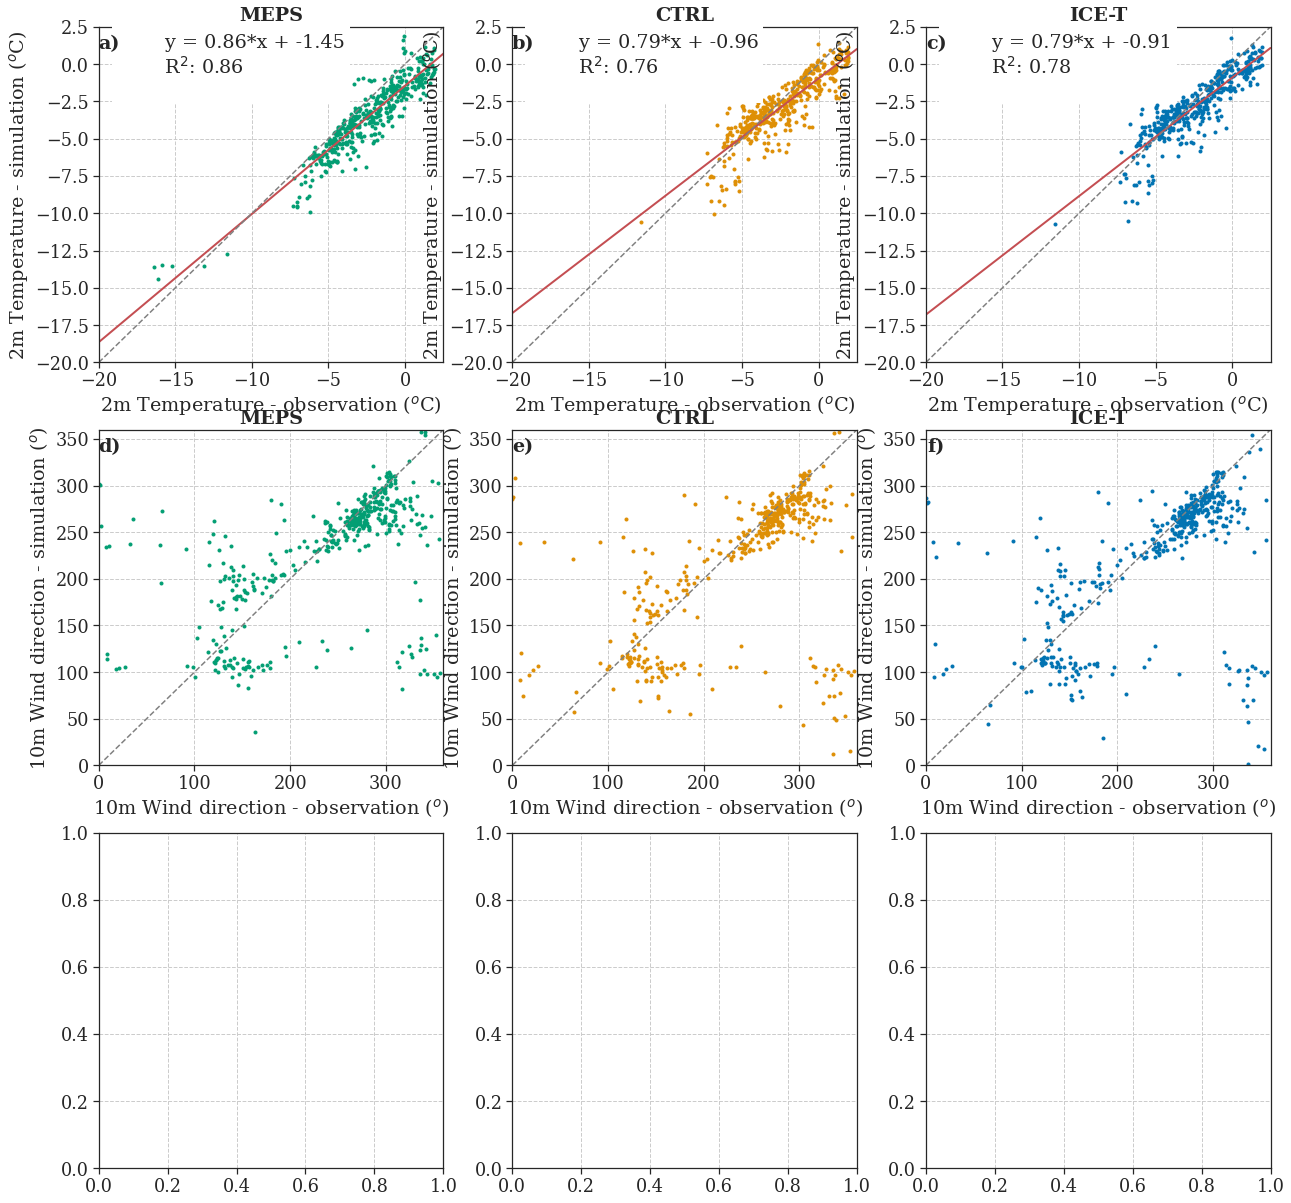

In [30]:
fig, axsm = plt.subplots(3, 3, figsize = [7*3, 7*3])
axs = axsm.flatten()
cc = [sns.color_palette("colorblind",5)[2], 
      sns.color_palette("colorblind",5)[1],
      sns.color_palette("colorblind",5)[0]]

# 2m temp
for i, mr,k in zip(range(3), meps_run, cc):
    axs[i].scatter(obs['2T_hourly'].where(obs['2T_hourly'] < 2.).where(obs['precip_hourly'] > 0), 
                   meps[mr]['2T'].where(meps[mr]['2T'] < 2.).where(meps[mr]['precip'] > 0), 
                   color = k, marker='.', )

    annoate_correlation(axs[i],
                        obs['2T_hourly'].where(obs['2T_hourly'] < 2.).where(obs['precip_hourly'] > 0),
                        meps[mr]['2T'].where(meps[mr]['2T'] < 2.).where(meps[mr]['precip'] > 0), var = 'temp')
    
    
    
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, ls='--', color='grey')
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].set_title(meps_run[i], fontweight = 'bold')
    
    axs[i].set_ylim([-20, 2.5])
    axs[i].set_xlim([-20, 2.5])
    axs[i].set_ylabel('2m Temperature - simulation ($^{o}$C)')
    axs[i].set_xlabel('2m Temperature - observation ($^{o}$C)')
    
# 10m WD
for i, mr,k in zip(np.arange(3, 6), meps_run, cc):
    axs[i].scatter(obs['WD_hourly'].where(obs['2T_hourly'] < 2.).where(obs['precip_hourly'] > 0), 
                   meps[mr]['WD'].where(meps[mr]['2T'] < 2.).where(meps[mr]['precip'] > 0), color = k, marker='.', )

#    annoate_correlation(axs[i],
 #                       obs['WD_hourly'].where(obs['2T_hourly'] < 2.).where(obs['precip_hourly'] > 0),
  #                      meps[mr]['WD'].where(meps[mr]['2T'] < 2.).where(meps[mr]['precip'] > 0))
    
    
    
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, ls='--', color='grey')
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].set_title(meps_run[i-3], fontweight = 'bold')
    
    axs[i].set_ylim([0, 360.])
    axs[i].set_xlim([0, 360.])
    axs[i].set_ylabel('10m Wind direction - simulation ($^{o}$)')
    axs[i].set_xlabel('10m Wind direction - observation ($^{o}$)')

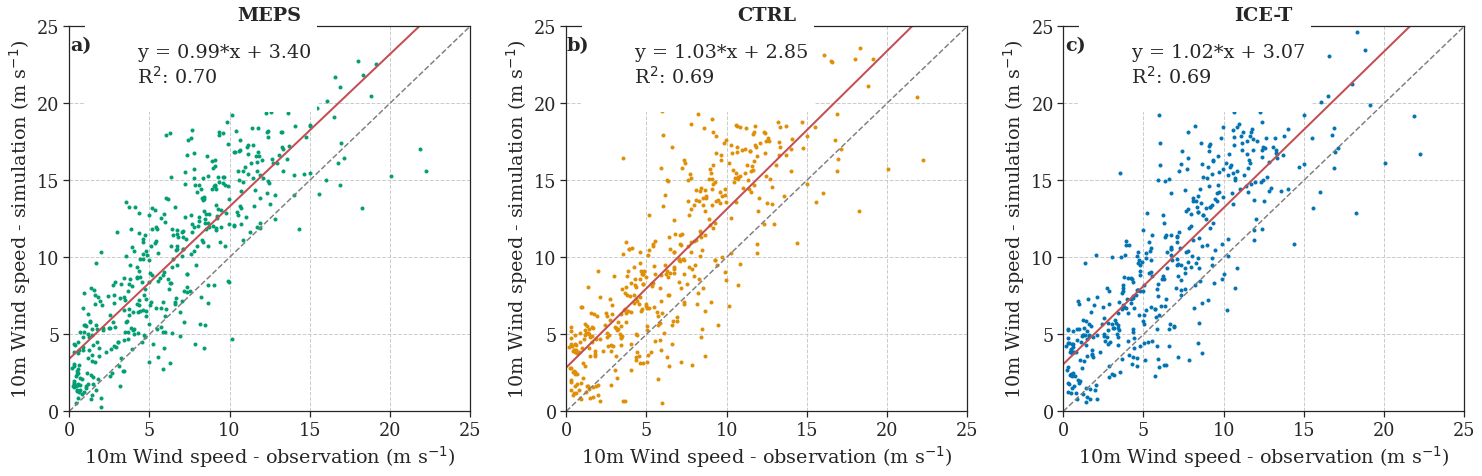

In [31]:
fig, axsm = plt.subplots(1, 3, figsize = [7*3, 7])
axs = axsm.flatten()
cc = [sns.color_palette("colorblind",5)[2], 
      sns.color_palette("colorblind",5)[1],
      sns.color_palette("colorblind",5)[0]]

# 10m WS
for i, mr,k in zip(range(len(axs)), meps_run, cc):
    axs[i].scatter(obs['WS_hourly'].where(obs['2T_hourly'] < 2.).where(obs['precip_hourly'] > 0), 
                   meps[mr]['WS'].where(meps[mr]['2T'] < 2.).where(meps[mr]['precip'] > 0), 
                   color = k, marker='.', )

    annoate_correlation(axs[i],
                        obs['WS_hourly'].where(obs['2T_hourly'] < 2.).where(obs['precip_hourly'] > 0),
                        meps[mr]['WS'].where(meps[mr]['2T'] < 2.).where(meps[mr]['precip'] > 0), var = 'ws')
    
    
    
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, ls='--', color='grey')
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].set_title(meps_run[i], fontweight = 'bold')
    
    axs[i].set_ylim([0, 25.])
    axs[i].set_xlim([0, 25.])
    axs[i].set_ylabel('10m Wind speed - simulation (m s$^{-1}$)')
    axs[i].set_xlabel('10m Wind speed - observation (m s$^{-1}$)')



    
plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_WS_correlation.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [32]:
# apply wind speed correction
# 1 gridpoint corrections
#meps['MEPS']['WS_corrected'] = (meps['MEPS']['WS'] - 3.03) / 1.
#meps['CTRL']['WS_corrected'] = (meps['CTRL']['WS'] - 2.67) / 1.08
#meps['ICE-T']['WS_corrected'] = (meps['ICE-T']['WS'] - 2.79) / 1.09
# 4 gridpoint corrections
meps['MEPS']['WS_corrected'] = (meps['MEPS']['WS'] - 3.4) / .99
meps['CTRL']['WS_corrected'] = (meps['CTRL']['WS'] - 2.85) / 1.03
meps['ICE-T']['WS_corrected'] = (meps['ICE-T']['WS'] - 3.07) / 1.02

In [33]:
# 1 gridpoint corrections
#meps['CTRL']['WS_2d_corrected'] = (meps['CTRL']['WS_2d'] - 2.67) / 1.08
#meps['ICE-T']['WS_2d_corrected'] = (meps['CTRL']['WS_2d'] - 2.79) / 1.09

# 4 gridpoint corrections
meps['CTRL']['WS_2d_corrected'] = (meps['CTRL']['WS_2d'] - 2.85) / 1.03
meps['ICE-T']['WS_2d_corrected'] = (meps['CTRL']['WS_2d'] - 3.07) / 1.02

In [34]:
for mr in meps_run:
    # West
    meps[mr]['precip_west_corre_0_4'] = meps[mr]['precip_west'].where(meps[mr]['WS_corrected'] < 4)
    meps[mr]['precip_west_corre_4_8'] = meps[mr]['precip_west'].where(np.logical_and(meps[mr]['WS_corrected'] >= 4., meps[mr]['WS_corrected'] < 8.))
    meps[mr]['precip_west_corre_8_12'] = meps[mr]['precip_west'].where(np.logical_and(meps[mr]['WS_corrected'] >= 8., meps[mr]['WS_corrected'] < 12.))
    meps[mr]['precip_west_corre_12_16'] = meps[mr]['precip_west'].where(np.logical_and(meps[mr]['WS_corrected'] >= 12., meps[mr]['WS_corrected'] < 16.))
    meps[mr]['precip_west_corre_16_20'] = meps[mr]['precip_west'].where(np.logical_and(meps[mr]['WS_corrected'] >= 16., meps[mr]['WS_corrected'] < 20.))
    meps[mr]['precip_west_corre_20'] = meps[mr]['precip_west'].where(meps[mr]['WS_corrected'] >= 20.)
    
    meps[mr]['precip_west_corre_ws'] = [meps[mr]['precip_west_corre_0_4'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_corre_4_8'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_corre_8_12'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_corre_12_16'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_corre_16_20'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_west_corre_20'].sum(axis=1, skipna= True).sum()]
    
    # getting number of nonzeros in each column is
    # df.astype(bool).sum(axis=0)

    meps[mr]['count_west_corre_ws'] = [meps[mr]['precip_west_corre_0_4'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_corre_4_8'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_corre_8_12'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_corre_12_16'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_corre_16_20'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_west_corre_20'].fillna(0).astype(bool).sum(axis = 0).sum(),]

    
    # East
    meps[mr]['precip_east_corre_0_4'] = meps[mr]['precip_east'].where(meps[mr]['WS_corrected'] < 4)
    meps[mr]['precip_east_corre_4_8'] = meps[mr]['precip_east'].where(np.logical_and(meps[mr]['WS_corrected'] >= 4., meps[mr]['WS_corrected'] < 8.))
    meps[mr]['precip_east_corre_8_12'] = meps[mr]['precip_east'].where(np.logical_and(meps[mr]['WS_corrected'] >= 8., meps[mr]['WS_corrected'] < 12.))
    meps[mr]['precip_east_corre_12_16'] = meps[mr]['precip_east'].where(np.logical_and(meps[mr]['WS_corrected'] >= 12., meps[mr]['WS_corrected'] < 16.))
    meps[mr]['precip_east_corre_16_20'] = meps[mr]['precip_east'].where(np.logical_and(meps[mr]['WS_corrected'] >= 16., meps[mr]['WS_corrected'] < 20.))
    meps[mr]['precip_east_corre_20'] = meps[mr]['precip_east'].where(meps[mr]['WS_corrected'] >= 20.)
    
    meps[mr]['precip_east_corre_ws'] = [meps[mr]['precip_east_corre_0_4'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_corre_4_8'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_corre_8_12'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_corre_12_16'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_corre_16_20'].sum(axis=1, skipna= True).sum(),
           meps[mr]['precip_east_corre_20'].sum(axis=1, skipna= True).sum()]
    
    # getting number of nonzeros in each column is
    # df.astype(bool).sum(axis=0)

    meps[mr]['count_east_corre_ws'] = [meps[mr]['precip_east_corre_0_4'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_corre_4_8'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_corre_8_12'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_corre_12_16'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_corre_16_20'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        meps[mr]['precip_east_corre_20'].fillna(0).astype(bool).sum(axis = 0).sum(),]

    if mr == 'CTRL' or mr == 'ICE-T':
        meps[mr]['SWC_west_corre_0_4'] = meps[mr]['SWC_hourly_west'].where(meps[mr]['WS_2d_corrected'] < 4.)
        meps[mr]['SWC_west_corre_4_8'] = meps[mr]['SWC_hourly_west'].where(np.logical_and(meps[mr]['WS_2d_corrected'] >= 4., meps[mr]['WS_2d_corrected'] < 8.))
        meps[mr]['SWC_west_corre_8_12'] = meps[mr]['SWC_hourly_west'].where(np.logical_and(meps[mr]['WS_2d_corrected'] >= 8., meps[mr]['WS_2d_corrected'] < 12.))
        meps[mr]['SWC_west_corre_12_16'] = meps[mr]['SWC_hourly_west'].where(np.logical_and(meps[mr]['WS_2d_corrected'] >= 12., meps[mr]['WS_2d_corrected'] < 16.))
        meps[mr]['SWC_west_corre_16_20'] = meps[mr]['SWC_hourly_west'].where(np.logical_and(meps[mr]['WS_2d_corrected'] >= 16., meps[mr]['WS_2d_corrected'] < 20.))
        meps[mr]['SWC_west_corre_20'] = meps[mr]['SWC_hourly_west'].where(meps[mr]['WS_2d_corrected'] >= 20.)

        meps[mr]['SWC_west_corre_ws'] = [meps[mr]['SWC_west_corre_0_4'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_west_corre_4_8'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_west_corre_8_12'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_west_corre_12_16'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_west_corre_16_20'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_west_corre_20'].sum(axis=1, skipna= True).sum()]
        
        meps[mr]['SWC_east_corre_0_4'] = meps[mr]['SWC_hourly_east'].where(meps[mr]['WS_2d_corrected'] < 4.)
        meps[mr]['SWC_east_corre_4_8'] = meps[mr]['SWC_hourly_east'].where(np.logical_and(meps[mr]['WS_2d_corrected'] >= 4., meps[mr]['WS_2d_corrected'] < 8.))
        meps[mr]['SWC_east_corre_8_12'] = meps[mr]['SWC_hourly_east'].where(np.logical_and(meps[mr]['WS_2d_corrected'] >= 8., meps[mr]['WS_2d_corrected'] < 12.))
        meps[mr]['SWC_east_corre_12_16'] = meps[mr]['SWC_hourly_east'].where(np.logical_and(meps[mr]['WS_2d_corrected'] >= 12., meps[mr]['WS_2d_corrected'] < 16.))
        meps[mr]['SWC_east_corre_16_20'] = meps[mr]['SWC_hourly_east'].where(np.logical_and(meps[mr]['WS_2d_corrected'] >= 16., meps[mr]['WS_2d_corrected'] < 20.))
        meps[mr]['SWC_east_corre_20'] = meps[mr]['SWC_hourly_east'].where(meps[mr]['WS_2d_corrected'] >= 20.)

        meps[mr]['SWC_east_corre_ws'] = [meps[mr]['SWC_east_corre_0_4'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_east_corre_4_8'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_east_corre_8_12'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_east_corre_12_16'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_east_corre_16_20'].sum(axis=1, skipna= True).sum(),
               meps[mr]['SWC_east_corre_20'].sum(axis=1, skipna= True).sum()]
    

In [35]:
# sort precipitation into Wind speed regimes

#West
obs['precip_west_hourly_0_4'] = obs['precip_west_hourly'].where(obs['WS_hourly'] < 4.)#[59::60]
obs['precip_west_hourly_4_8'] = obs['precip_west_hourly'].where(np.logical_and(obs['WS_hourly'] >= 4., obs['WS_hourly'] < 8.))
obs['precip_west_hourly_8_12'] = obs['precip_west_hourly'].where(np.logical_and(obs['WS_hourly'] >= 8., obs['WS_hourly'] < 12.))
obs['precip_west_hourly_12_16'] = obs['precip_west_hourly'].where(np.logical_and(obs['WS_hourly'] >= 12., obs['WS_hourly'] < 16.))
obs['precip_west_hourly_16_20'] = obs['precip_west_hourly'].where(np.logical_and(obs['WS_hourly'] >= 16., obs['WS_hourly'] < 20.))
obs['precip_west_hourly_20'] = obs['precip_west_hourly'].where(obs['WS_hourly'] >= 20., )

#East
obs['precip_east_hourly_0_4'] = obs['precip_east_hourly'].where(obs['WS_hourly'] < 4.)
obs['precip_east_hourly_4_8'] = obs['precip_east_hourly'].where(np.logical_and(obs['WS_hourly'] >= 4., obs['WS_hourly'] < 8.))
obs['precip_east_hourly_8_12'] = obs['precip_east_hourly'].where(np.logical_and(obs['WS_hourly'] >= 8., obs['WS_hourly'] < 12.))
obs['precip_east_hourly_12_16'] = obs['precip_east_hourly'].where(np.logical_and(obs['WS_hourly'] >= 12., obs['WS_hourly'] < 16.))
obs['precip_east_hourly_16_20'] = obs['precip_east_hourly'].where(np.logical_and(obs['WS_hourly'] >= 16., obs['WS_hourly'] < 20.))
obs['precip_east_hourly_20'] = obs['precip_east_hourly'].where(obs['WS'] >= 20., )

In [36]:
#West
obs['precip_west_ws'] = [obs['precip_west_hourly_0_4'].sum(axis=1, skipna= True).sum(),
           obs['precip_west_hourly_4_8'].sum(axis=1, skipna= True).sum(),
           obs['precip_west_hourly_8_12'].sum(axis=1, skipna= True).sum(),
           obs['precip_west_hourly_12_16'].sum(axis=1, skipna= True).sum(),
           obs['precip_west_hourly_16_20'].sum(axis=1, skipna= True).sum(),
           obs['precip_west_hourly_20'].sum(axis=1, skipna= True).sum()]
#East
obs['precip_east_ws'] = [obs['precip_east_hourly_0_4'].sum(axis=1, skipna= True).sum(),
           obs['precip_east_hourly_4_8'].sum(axis=1, skipna= True).sum(),
           obs['precip_east_hourly_8_12'].sum(axis=1, skipna= True).sum(),
           obs['precip_east_hourly_12_16'].sum(axis=1, skipna= True).sum(),
           obs['precip_east_hourly_16_20'].sum(axis=1, skipna= True).sum(),
           obs['precip_east_hourly_20'].sum(axis=1, skipna= True).sum()]

In [37]:
#West
ret['precip_west_hourly_0_4'] = ret['precip_west_hourly'].where(ret['WS_hourly'] < 4.)
ret['precip_west_hourly_4_8'] = ret['precip_west_hourly'].where(np.logical_and(ret['WS_hourly'] >= 4., ret['WS_hourly'] < 8.))
ret['precip_west_hourly_8_12'] = ret['precip_west_hourly'].where(np.logical_and(ret['WS_hourly'] >= 8., ret['WS_hourly'] < 12.))
ret['precip_west_hourly_12_16'] = ret['precip_west_hourly'].where(np.logical_and(ret['WS_hourly'] >= 12., ret['WS_hourly'] < 16.))
ret['precip_west_hourly_16_20'] = ret['precip_west_hourly'].where(np.logical_and(ret['WS_hourly'] >= 16., ret['WS_hourly'] < 20.))
ret['precip_west_hourly_20'] = ret['precip_west_hourly'].where(ret['WS_hourly'] >= 20., )

#East
ret['precip_east_hourly_0_4'] = ret['precip_east_hourly'].where(ret['WS_hourly'] < 4.)
ret['precip_east_hourly_4_8'] = ret['precip_east_hourly'].where(np.logical_and(ret['WS_hourly'] >= 4., ret['WS_hourly'] < 8.))
ret['precip_east_hourly_8_12'] = ret['precip_east_hourly'].where(np.logical_and(ret['WS_hourly'] >= 8., ret['WS_hourly'] < 12.))
ret['precip_east_hourly_12_16'] = ret['precip_east_hourly'].where(np.logical_and(ret['WS_hourly'] >= 12., ret['WS_hourly'] < 16.))
ret['precip_east_hourly_16_20'] = ret['precip_east_hourly'].where(np.logical_and(ret['WS_hourly'] >= 16., ret['WS_hourly'] < 20.))
ret['precip_east_hourly_20'] = ret['precip_east_hourly'].where(ret['WS_hourly'] >= 20., )


In [38]:
#West
ret['precip_west_ws'] = [ret['precip_west_hourly_0_4'].sum(axis=1, skipna= True).sum(),
           ret['precip_west_hourly_4_8'].sum(axis=1, skipna= True).sum(),
           ret['precip_west_hourly_8_12'].sum(axis=1, skipna= True).sum(),
           ret['precip_west_hourly_12_16'].sum(axis=1, skipna= True).sum(),
           ret['precip_west_hourly_16_20'].sum(axis=1, skipna= True).sum(),
           ret['precip_west_hourly_20'].sum(axis=1, skipna= True).sum()]

#East
ret['precip_east_ws'] = [ret['precip_east_hourly_0_4'].sum(axis=1, skipna= True).sum(),
           ret['precip_east_hourly_4_8'].sum(axis=1, skipna= True).sum(),
           ret['precip_east_hourly_8_12'].sum(axis=1, skipna= True).sum(),
           ret['precip_east_hourly_12_16'].sum(axis=1, skipna= True).sum(),
           ret['precip_east_hourly_16_20'].sum(axis=1, skipna= True).sum(),
           ret['precip_east_hourly_20'].sum(axis=1, skipna= True).sum()]

In [39]:
# getting number of nonzeros in each column is
# df.astype(bool).sum(axis=0)

obs['count_west_ws'] = [obs['precip_west_hourly_0_4'].where(obs['precip_west_hourly_0_4'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_west_hourly_4_8'].where(obs['precip_west_hourly_4_8'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_west_hourly_8_12'].where(obs['precip_west_hourly_8_12'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_west_hourly_12_16'].where(obs['precip_west_hourly_12_16'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_west_hourly_16_20'].where(obs['precip_west_hourly_16_20'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_west_hourly_20'].where(obs['precip_west_hourly_20'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),]

obs['count_east_ws'] = [obs['precip_east_hourly_0_4'].where(obs['precip_east_hourly_0_4'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_east_hourly_4_8'].where(obs['precip_east_hourly_4_8'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_east_hourly_8_12'].where(obs['precip_east_hourly_8_12'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_east_hourly_12_16'].where(obs['precip_east_hourly_12_16'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_east_hourly_16_20'].where(obs['precip_east_hourly_16_20'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),
                        obs['precip_east_hourly_20'].where(obs['precip_east_hourly_20'] > 0).fillna(0).astype(bool).sum(axis = 0).sum(),]



In [40]:
ret['count_west_ws'] = [ret['precip_west_hourly_0_4'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_west_hourly_4_8'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_west_hourly_8_12'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_west_hourly_12_16'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_west_hourly_16_20'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_west_hourly_20'].fillna(0).astype(bool).sum(axis = 0).sum(),]

ret['count_east_ws'] = [ret['precip_east_hourly_0_4'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_east_hourly_4_8'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_east_hourly_8_12'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_east_hourly_12_16'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_east_hourly_16_20'].fillna(0).astype(bool).sum(axis = 0).sum(),
                        ret['precip_east_hourly_20'].fillna(0).astype(bool).sum(axis = 0).sum(),]


In [41]:
def plt_bar_obs_ret_meps(axs, west, x, observation, color = None):
    bar_width = 0.16
    opacity = 0.8
    
    bar = axs.bar(np.arange(len(west)) + x*bar_width,
                  west[:], width = bar_width,
                  align = 'center', alpha = opacity, #color = plt.get_cmap('Spectral_r'), #color = sns.color_palette("colorblind",5)[0]
                    color = color,
                  label = '$\sum${:}: {:.0f}'.format(observation,np.nansum(west[:])))
    
    axs.set_xticks(np.arange(len(west)))
    axs.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'],                         rotation=20)
    axs.set_xlabel('Wind speed (m/s)')

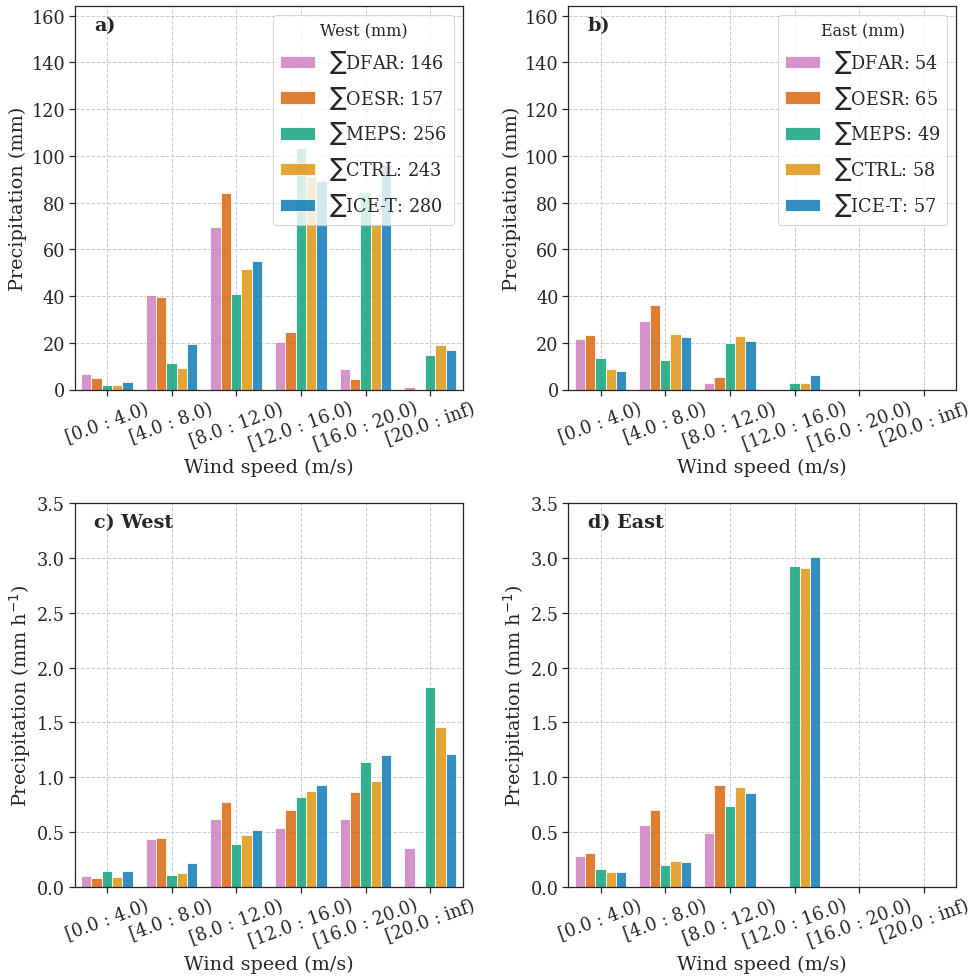

In [42]:
fig, axsm = plt.subplots(2, 2, figsize = [14,14])
axs = axsm.flatten()

#West
plt_bar_obs_ret_meps(axs[0], obs['precip_west_ws'], -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[0], ret['precip_west_ws'], -1, 'OESR', sns.color_palette("colorblind",5)[3])

for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[0], meps[mr]['precip_west_ws'], i, mr, k)


#East
plt_bar_obs_ret_meps(axs[1], obs['precip_east_ws'], -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[1], ret['precip_east_ws'], -1, 'OESR', sns.color_palette("colorblind",5)[3])
for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[1], meps[mr]['precip_east_ws'], i, mr, k)

for i, _t in zip(range(2), ['West (mm)', 'East (mm)']):
    axs[i].legend(loc = 'upper right', 
              fancybox=True, facecolor ='white', title = _t, title_fontsize=16)
    axs[i].set_ylabel('Precipitation (mm)')
    axs[i].set_ylim([0, 164])
    axs[i].set_xlim([-0.5, 5.5])
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    
    
#### precipitation per hour
plt_bar_obs_ret_meps(axs[2], np.array(obs['precip_west_ws'])/np.array(obs['count_west_ws']), -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[2], np.array(ret['precip_west_ws'])/np.array(ret['count_west_ws']), -1, 'OESR', sns.color_palette("colorblind",5)[3])
for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[2], np.array(meps[mr]['precip_west_ws'])/np.array(meps[mr]['count_west_ws']), i, mr, k)
    
plt_bar_obs_ret_meps(axs[3], np.array(obs['precip_east_ws'])/np.array(obs['count_east_ws']), -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[3], np.array(ret['precip_east_ws'])/np.array(ret['count_east_ws']), -1, 'OESR', sns.color_palette("colorblind",5)[3])
for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[3], np.array(meps[mr]['precip_east_ws'])/np.array(meps[mr]['count_east_ws']), i, mr, k)

    
for i, _t in zip(range(2,4), ['West', 'East']):
#    axs[i].legend(loc = 'upper right', 
 #             fancybox=True, facecolor ='white', title = _t, title_fontsize=16)
    axs[i].set_ylabel('Precipitation (mm h$^{-1}$)')
    axs[i].set_ylim([0, 3.5])
    axs[i].set_xlim([-0.5, 5.5])
    axs[i].text(0.05, 0.95,
                    '{:} {:}'.format(fig_label[i], _t),
                    fontweight='bold',
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = axs[i].transAxes)

    
    
plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_precip_WS_WD_count.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [43]:
# Plot the precipitation for the corrected wind speed in the simulations

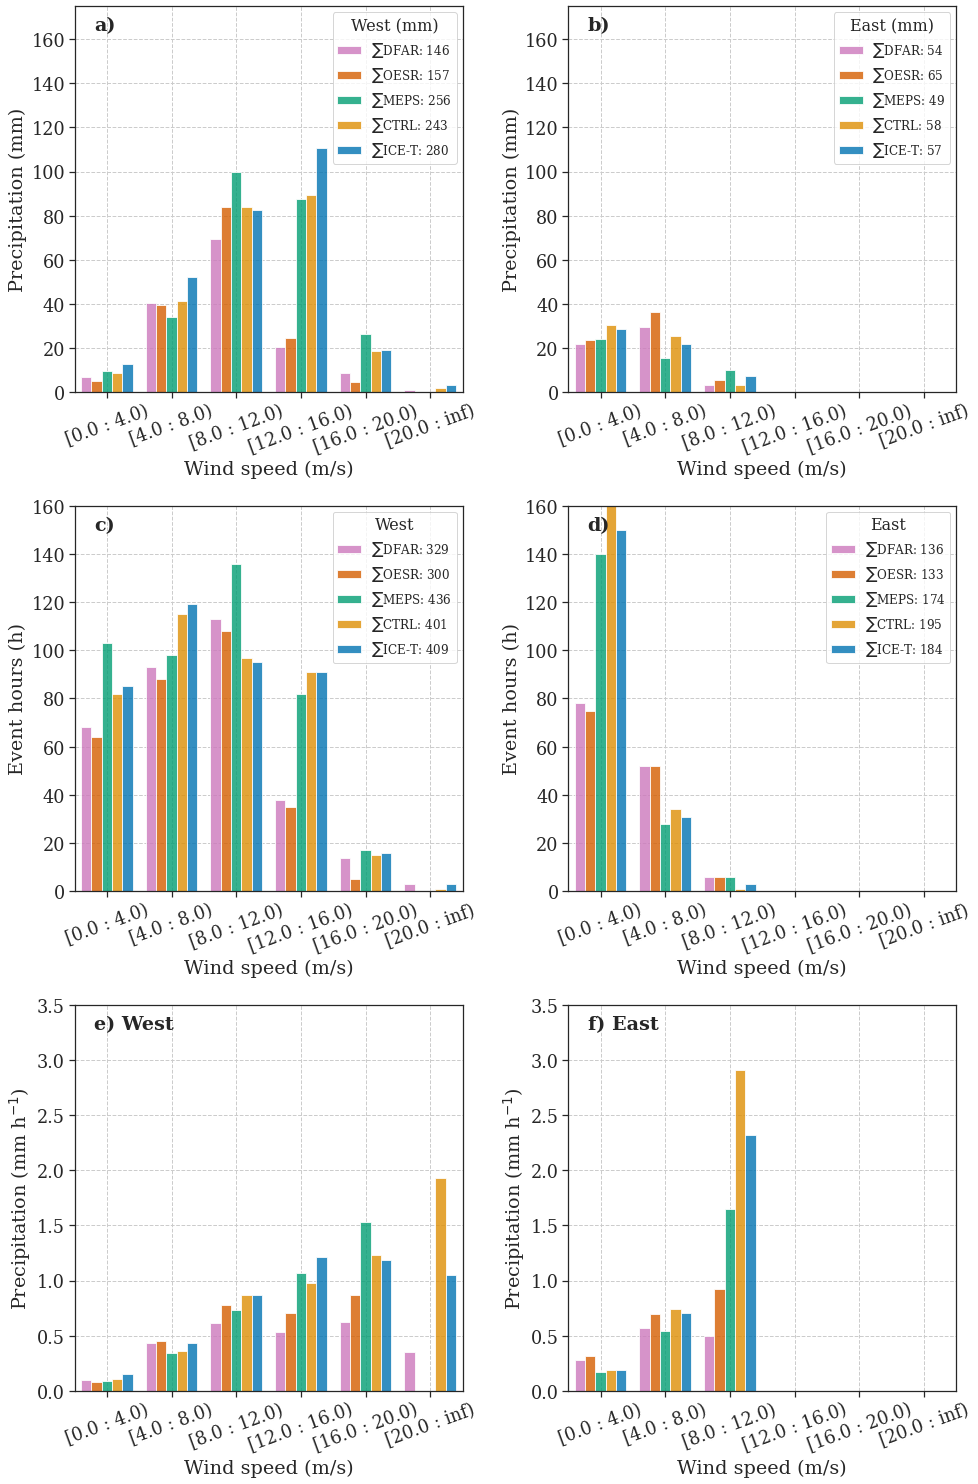

In [44]:
fig, axsm = plt.subplots(3, 2, figsize = [14,21])
axs = axsm.flatten()

#West
plt_bar_obs_ret_meps(axs[0], obs['precip_west_ws'], -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[0], ret['precip_west_ws'], -1, 'OESR', sns.color_palette("colorblind",5)[3])

for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[0], meps[mr]['precip_west_corre_ws'], i, mr, k)


#East
plt_bar_obs_ret_meps(axs[1], obs['precip_east_ws'], -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[1], ret['precip_east_ws'], -1, 'OESR', sns.color_palette("colorblind",5)[3])
for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[1], meps[mr]['precip_east_corre_ws'], i, mr, k)

for i, _t in zip(range(2), ['West (mm)', 'East (mm)']):
    axs[i].legend(loc = 'upper right', 
              fancybox=True, facecolor ='white', title = _t, title_fontsize=16, fontsize = 12)
    axs[i].set_ylabel('Precipitation (mm)')
    axs[i].set_ylim([0, 175])
    axs[i].set_xlim([-0.5, 5.5])
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    
    
    
plt_bar_obs_ret_meps(axs[2], np.array(obs['count_west_ws']), -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[2], np.array(ret['count_west_ws']), -1, 'OESR', sns.color_palette("colorblind",5)[3])
for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[2], np.array(meps[mr]['count_west_corre_ws']), i, mr, k)
    
plt_bar_obs_ret_meps(axs[3], np.array(obs['count_east_ws']), -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[3], np.array(ret['count_east_ws']), -1, 'OESR', sns.color_palette("colorblind",5)[3])
for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[3], np.array(meps[mr]['count_east_corre_ws']), i, mr, k)

    
for i, _t in zip(range(2,4), ['West', 'East']):
    axs[i].legend(loc = 'upper right', 
              fancybox=True, facecolor ='white', title = _t, title_fontsize=16, fontsize = 12)
    axs[i].set_ylabel('Event hours (h)')
    axs[i].set_ylim([0, 160])
    axs[i].set_xlim([-0.5, 5.5])
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    
#### precipitation per hour
plt_bar_obs_ret_meps(axs[4], np.array(obs['precip_west_ws'])/np.array(obs['count_west_ws']), -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[4], np.array(ret['precip_west_ws'])/np.array(ret['count_west_ws']), -1, 'OESR', sns.color_palette("colorblind",5)[3])
for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[4], np.array(meps[mr]['precip_west_corre_ws'])/np.array(meps[mr]['count_west_corre_ws']), i, mr, k)
    
plt_bar_obs_ret_meps(axs[5], np.array(obs['precip_east_ws'])/np.array(obs['count_east_ws']), -2, 'DFAR', sns.color_palette("colorblind",5)[4])
plt_bar_obs_ret_meps(axs[5], np.array(ret['precip_east_ws'])/np.array(ret['count_east_ws']), -1, 'OESR', sns.color_palette("colorblind",5)[3])
for mr, i, k in zip(meps_run, range(len(meps_run)), cc):
    plt_bar_obs_ret_meps(axs[5], np.array(meps[mr]['precip_east_corre_ws'])/np.array(meps[mr]['count_east_corre_ws']), i, mr, k)

    
for i, _t in zip(range(4,6), ['West', 'East']):
    #    axs[i].legend(loc = 'upper right', 
 #             fancybox=True, facecolor ='white', title = _t, title_fontsize=16)
    axs[i].set_ylabel('Precipitation (mm h$^{-1}$)')
    axs[i].set_ylim([0, 3.5])
    axs[i].set_xlim([-0.5, 5.5])
    axs[i].text(0.05, 0.95,
                    '{:} {:}'.format(fig_label[i], _t),
                    fontweight='bold',
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = axs[i].transAxes)


    
    
plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_precip_WS_WD_count_correction.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [45]:
ret['SWC_west_hourly_0_4']  = ret['SWC_west_hourly'].where(ret['WS_2d'] < 4.)
ret['SWC_west_hourly_4_8'] = ret['SWC_west_hourly'].where(np.logical_and(ret['WS_2d'] >= 4., ret['WS_2d'] < 8.))
ret['SWC_west_hourly_8_12'] = ret['SWC_west_hourly'].where(np.logical_and(ret['WS_2d'] >= 8., ret['WS_2d'] < 12.))
ret['SWC_west_hourly_12_16'] = ret['SWC_west_hourly'].where(np.logical_and(ret['WS_2d'] >= 12., ret['WS_2d'] < 16.))
ret['SWC_west_hourly_16_20'] = ret['SWC_west_hourly'].where(np.logical_and(ret['WS_2d'] >= 16., ret['WS_2d'] < 20.))
ret['SWC_west_hourly_20'] = ret['SWC_west_hourly'].where(ret['WS_2d'] >= 20.)


In [46]:
ret['SWC_east_hourly_0_4']  = ret['SWC_east_hourly'].where(ret['WS_2d'] < 4.)
ret['SWC_east_hourly_4_8'] = ret['SWC_east_hourly'].where(np.logical_and(ret['WS_2d'] >= 4., ret['WS_2d'] < 8.))
ret['SWC_east_hourly_8_12'] = ret['SWC_east_hourly'].where(np.logical_and(ret['WS_2d'] >= 8., ret['WS_2d'] < 12.))
ret['SWC_east_hourly_12_16'] = ret['SWC_east_hourly'].where(np.logical_and(ret['WS_2d'] >= 12., ret['WS_2d'] < 16.))
ret['SWC_east_hourly_16_20'] = ret['SWC_east_hourly'].where(np.logical_and(ret['WS_2d'] >= 16., ret['WS_2d'] < 20.))
ret['SWC_east_hourly_20'] = ret['SWC_east_hourly'].where(ret['WS_2d'] >= 20.)


In [47]:
def plt_vert_profile_mean_std(axs, SWC, label, color,):
    axs.plot(SWC.mean(axis = 0, skipna = True),
                np.arange(400, 3200, 200), label = label, color = color, alpha = 0.8, linewidth = 1.5)
    axs.plot(SWC.std(axis = 0, skipna = True),
                np.arange(400, 3200, 200), color = color, linestyle = '--')
    
    

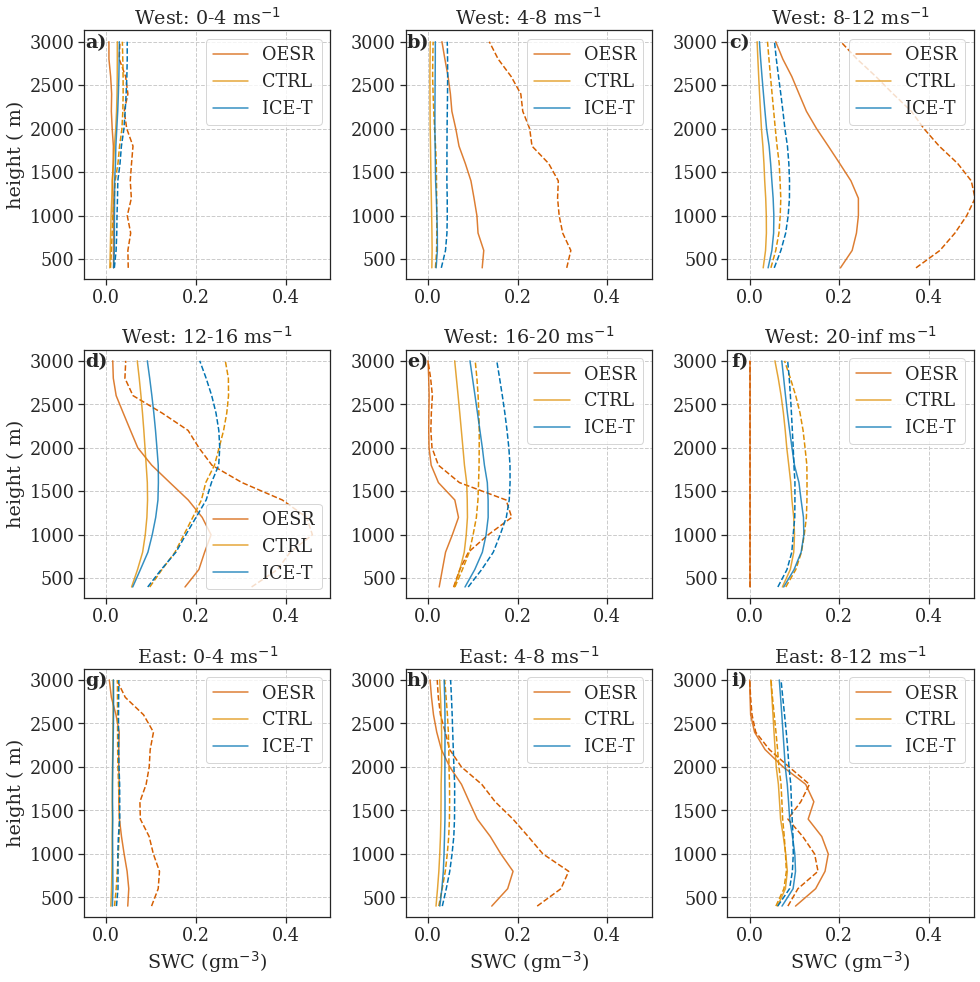

In [48]:
fig, axsm = plt.subplots(3, 3, figsize = [14,14], )
axs = axsm.flatten()

#0-4 ms-1
plt_vert_profile_mean_std(axs[0], ret['SWC_west_hourly_0_4'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[0], meps['CTRL']['SWC_west_hourly_0_4'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[0], meps['ICE-T']['SWC_west_hourly_0_4'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#4-8 ms-1
plt_vert_profile_mean_std(axs[1], ret['SWC_west_hourly_4_8'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[1], meps['CTRL']['SWC_west_hourly_4_8'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[1], meps['ICE-T']['SWC_west_hourly_4_8'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#8-12 ms-1
plt_vert_profile_mean_std(axs[2], ret['SWC_west_hourly_8_12'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[2], meps['CTRL']['SWC_west_hourly_8_12'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[2], meps['ICE-T']['SWC_west_hourly_8_12'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#12-16 ms-1
plt_vert_profile_mean_std(axs[3], ret['SWC_west_hourly_12_16'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[3], meps['CTRL']['SWC_west_hourly_12_16'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[3], meps['ICE-T']['SWC_west_hourly_12_16'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#16-20 ms-1
plt_vert_profile_mean_std(axs[4], ret['SWC_west_hourly_16_20'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[4], meps['CTRL']['SWC_west_hourly_16_20'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[4], meps['ICE-T']['SWC_west_hourly_16_20'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#20-inf ms-1
plt_vert_profile_mean_std(axs[5], ret['SWC_west_hourly_20'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[5], meps['CTRL']['SWC_west_hourly_20'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[5], meps['ICE-T']['SWC_west_hourly_20'], 'ICE-T', sns.color_palette("colorblind",5)[0], )


#0-4 ms-1
plt_vert_profile_mean_std(axs[6], ret['SWC_east_hourly_0_4'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[6], meps['CTRL']['SWC_east_hourly_0_4'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[6], meps['ICE-T']['SWC_east_hourly_0_4'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#4-8 ms-1
plt_vert_profile_mean_std(axs[7], ret['SWC_east_hourly_4_8'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[7], meps['CTRL']['SWC_east_hourly_4_8'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[7], meps['ICE-T']['SWC_east_hourly_4_8'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#8-12 ms-1
plt_vert_profile_mean_std(axs[8], ret['SWC_east_hourly_8_12'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[8], meps['CTRL']['SWC_east_hourly_8_12'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[8], meps['ICE-T']['SWC_east_hourly_8_12'], 'ICE-T', sns.color_palette("colorblind",5)[0], )


title = ['West: 0-4 ms$^{-1}$',
      'West: 4-8 ms$^{-1}$',
      'West: 8-12 ms$^{-1}$',
      'West: 12-16 ms$^{-1}$',
      'West: 16-20 ms$^{-1}$',
      'West: 20-inf ms$^{-1}$',
      'East: 0-4 ms$^{-1}$',
      'East: 4-8 ms$^{-1}$',
      'East: 8-12 ms$^{-1}$']
for i, t in zip(range(len(axs)), title):
    axs[i].text(0.5, 1.05,
                    t,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)

    axs[i].legend(loc = 'best')
    axs[i].set_xlim([-0.05,0.5])
    if i == 0 or i == 3 or i == 6:
        axs[i].set_ylabel('height ( m)')
    if i == 6 or i == 7 or i == 8:
        axs[i].set_xlabel('SWC (gm$^{-3}$)')
        
plt.tight_layout()
if savefig == 1:
    fig_name = 'winter_16_17_SWC_WD_WS_mean_std.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

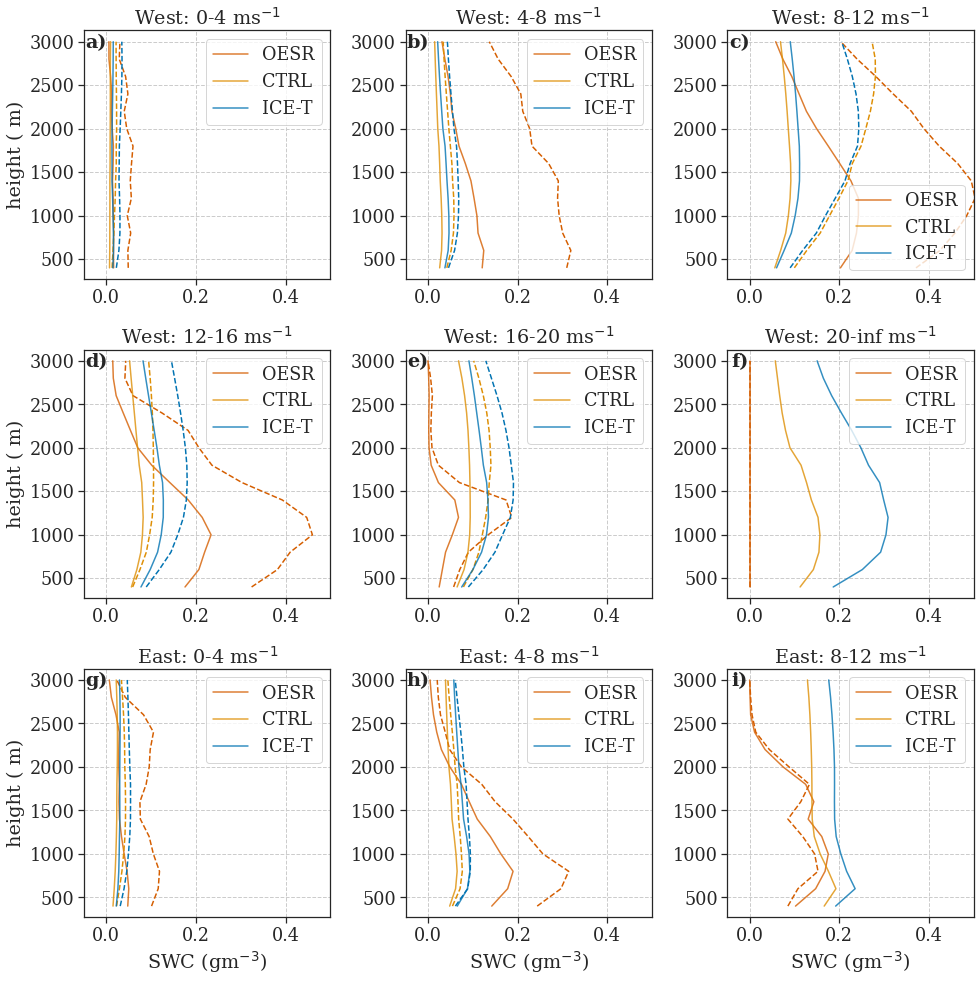

In [49]:
# plot for corrected wind speed

fig, axsm = plt.subplots(3, 3, figsize = [14,14], )
axs = axsm.flatten()

#0-4 ms-1
plt_vert_profile_mean_std(axs[0], ret['SWC_west_hourly_0_4'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[0], meps['CTRL']['SWC_west_corre_0_4'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[0], meps['ICE-T']['SWC_west_corre_0_4'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#4-8 ms-1
plt_vert_profile_mean_std(axs[1], ret['SWC_west_hourly_4_8'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[1], meps['CTRL']['SWC_west_corre_4_8'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[1], meps['ICE-T']['SWC_west_corre_4_8'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#8-12 ms-1
plt_vert_profile_mean_std(axs[2], ret['SWC_west_hourly_8_12'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[2], meps['CTRL']['SWC_west_corre_8_12'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[2], meps['ICE-T']['SWC_west_corre_8_12'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#12-16 ms-1
plt_vert_profile_mean_std(axs[3], ret['SWC_west_hourly_12_16'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[3], meps['CTRL']['SWC_west_corre_12_16'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[3], meps['ICE-T']['SWC_west_corre_12_16'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#16-20 ms-1
plt_vert_profile_mean_std(axs[4], ret['SWC_west_hourly_16_20'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[4], meps['CTRL']['SWC_west_corre_16_20'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[4], meps['ICE-T']['SWC_west_corre_16_20'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#20-inf ms-1
plt_vert_profile_mean_std(axs[5], ret['SWC_west_hourly_20'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[5], meps['CTRL']['SWC_west_corre_20'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[5], meps['ICE-T']['SWC_west_corre_20'], 'ICE-T', sns.color_palette("colorblind",5)[0], )


#0-4 ms-1
plt_vert_profile_mean_std(axs[6], ret['SWC_east_hourly_0_4'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[6], meps['CTRL']['SWC_east_corre_0_4'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[6], meps['ICE-T']['SWC_east_corre_0_4'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#4-8 ms-1
plt_vert_profile_mean_std(axs[7], ret['SWC_east_hourly_4_8'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[7], meps['CTRL']['SWC_east_corre_4_8'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[7], meps['ICE-T']['SWC_east_corre_4_8'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#8-12 ms-1
plt_vert_profile_mean_std(axs[8], ret['SWC_east_hourly_8_12'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[8], meps['CTRL']['SWC_east_corre_8_12'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[8], meps['ICE-T']['SWC_east_corre_8_12'], 'ICE-T', sns.color_palette("colorblind",5)[0], )


title = ['West: 0-4 ms$^{-1}$',
      'West: 4-8 ms$^{-1}$',
      'West: 8-12 ms$^{-1}$',
      'West: 12-16 ms$^{-1}$',
      'West: 16-20 ms$^{-1}$',
      'West: 20-inf ms$^{-1}$',
      'East: 0-4 ms$^{-1}$',
      'East: 4-8 ms$^{-1}$',
      'East: 8-12 ms$^{-1}$']
for i, t in zip(range(len(axs)), title):
    axs[i].text(0.5, 1.05,
                    t,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)

    axs[i].legend(loc = 'best')
    axs[i].set_xlim([-0.05,0.5])
    if i == 0 or i == 3 or i == 6:
        axs[i].set_ylabel('height ( m)')
    if i == 6 or i == 7 or i == 8:
        axs[i].set_xlabel('SWC (gm$^{-3}$)')
        
plt.tight_layout()
if savefig == 1:
    fig_name = 'winter_16_17_SWC_WD_WS_mean_std_correction.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

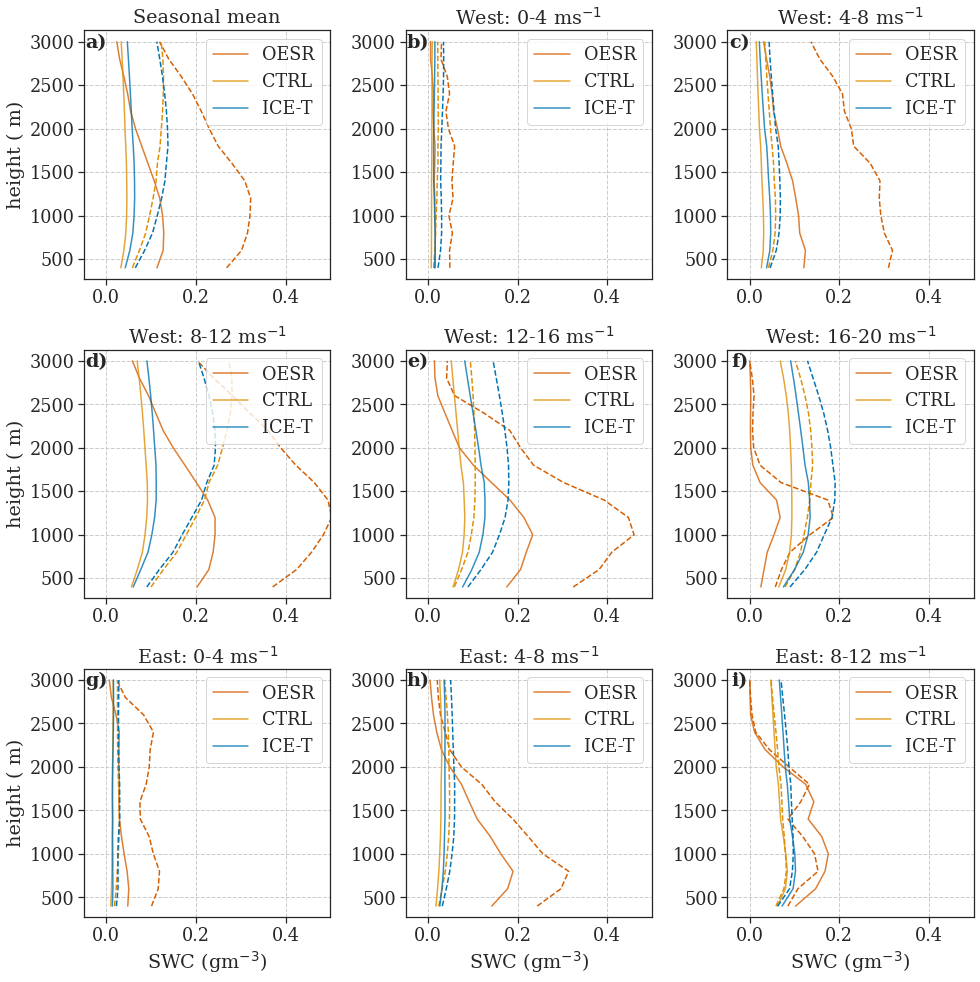

In [50]:
# plot for corrected wind speed

fig, axsm = plt.subplots(3, 3, figsize = [14,14], )
axs = axsm.flatten()
plt_vert_profile_mean_std(axs[0], ret['SWC_hourly'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[0], meps['CTRL']['SWC_hourly'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[0], meps['ICE-T']['SWC_hourly'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#0-4 ms-1
plt_vert_profile_mean_std(axs[0+1], ret['SWC_west_hourly_0_4'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[0+1], meps['CTRL']['SWC_west_corre_0_4'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[0+1], meps['ICE-T']['SWC_west_corre_0_4'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#4-8 ms-1
plt_vert_profile_mean_std(axs[1+1], ret['SWC_west_hourly_4_8'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[1+1], meps['CTRL']['SWC_west_corre_4_8'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[1+1], meps['ICE-T']['SWC_west_corre_4_8'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#8-12 ms-1
plt_vert_profile_mean_std(axs[2+1], ret['SWC_west_hourly_8_12'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[2+1], meps['CTRL']['SWC_west_corre_8_12'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[2+1], meps['ICE-T']['SWC_west_corre_8_12'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#12-16 ms-1
plt_vert_profile_mean_std(axs[3+1], ret['SWC_west_hourly_12_16'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[3+1], meps['CTRL']['SWC_west_corre_12_16'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[3+1], meps['ICE-T']['SWC_west_corre_12_16'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#16-20 ms-1
plt_vert_profile_mean_std(axs[4+1], ret['SWC_west_hourly_16_20'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[4+1], meps['CTRL']['SWC_west_corre_16_20'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[4+1], meps['ICE-T']['SWC_west_corre_16_20'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#0-4 ms-1
plt_vert_profile_mean_std(axs[6], ret['SWC_east_hourly_0_4'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[6], meps['CTRL']['SWC_east_hourly_0_4'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[6], meps['ICE-T']['SWC_east_hourly_0_4'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#4-8 ms-1
plt_vert_profile_mean_std(axs[7], ret['SWC_east_hourly_4_8'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[7], meps['CTRL']['SWC_east_hourly_4_8'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[7], meps['ICE-T']['SWC_east_hourly_4_8'], 'ICE-T', sns.color_palette("colorblind",5)[0], )

#8-12 ms-1
plt_vert_profile_mean_std(axs[8], ret['SWC_east_hourly_8_12'], 'OESR', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[8], meps['CTRL']['SWC_east_hourly_8_12'], 'CTRL', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[8], meps['ICE-T']['SWC_east_hourly_8_12'], 'ICE-T', sns.color_palette("colorblind",5)[0], )


title = ['Seasonal mean',
      'West: 0-4 ms$^{-1}$',
      'West: 4-8 ms$^{-1}$',
      'West: 8-12 ms$^{-1}$',
      'West: 12-16 ms$^{-1}$',
      'West: 16-20 ms$^{-1}$',
      'East: 0-4 ms$^{-1}$',
      'East: 4-8 ms$^{-1}$',
      'East: 8-12 ms$^{-1}$']
for i, t in zip(range(len(axs)), title):
    axs[i].text(0.5, 1.05,
                    t,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)

    axs[i].legend(loc = 'upper right')
    axs[i].set_xlim([-0.05,0.5])
    if i == 0 or i == 3 or i == 6:
        axs[i].set_ylabel('height ( m)')
    if i == 6 or i == 7 or i == 8:
        axs[i].set_xlabel('SWC (gm$^{-3}$)')
        
plt.tight_layout()
if savefig == 1:
    fig_name = 'winter_16_17_SWC_WD_WS_mean_std_correction_V2.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

In [109]:
def plt_vert_profile_mean(axs, SWC, label, color,):
    axs.plot(SWC.mean(axis = 0, skipna = True),
                np.arange(400, 3200, 200), label = label, color = color, alpha = 0.8, 
                linewidth = 3.5)
    # axs.plot(SWC.std(axis = 0, skipna = True),
    #             np.arange(400, 3200, 200), color = color, linestyle = '--')

In [111]:
savefig = 1
figdir = '/home/franzihe/Documents/Figures/BAMS_Haukeli'
cF.createFolder('%s/' %figdir)
form = 'png'

In [113]:
# plot for corrected wind speed only seasonal mean (for BAMS)

fig, axsm = plt.subplots(1, 1, figsize = [12,14], )
axs = axsm#.flatten()
plt_vert_profile_mean(axs, ret['SWC_hourly'], 'OESR', sns.color_palette("colorblind",10)[2], )
plt_vert_profile_mean(axs, meps['CTRL']['SWC_hourly'], 'CTRL', sns.color_palette("colorblind",10)[1], )
plt_vert_profile_mean(axs, meps['ICE-T']['SWC_hourly'], 'ICE-T', sns.color_palette("colorblind",10)[9], )



title = ['Seasonal mean']
for t in title:
    axs.text(0.5, 1.05,
                    t,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs.transAxes)
    # axs.text(0.05, 0.95,
    #                 fig_label[0],
    #                 fontweight='bold',
    #                 horizontalalignment='center',
    #                 verticalalignment='center',
    #                 transform = axs.transAxes)

    axs.legend(loc = 'upper right')
    axs.set_xlim([-0.0,0.15])
    # if i == 0 or i == 3 or i == 6:
    axs.set_ylabel('height ( m)')
    # if i == 6 or i == 7 or i == 8:
    axs.set_xlabel('SWC (gm$^{-3}$)')
        
plt.tight_layout()
if savefig == 1:
    fig_name = 'winter_16_17_SWC_mean_correction.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

plot saved: /home/franzihe/Documents/Figures/BAMS_Haukeli/winter_16_17_SWC_mean_correction.png


In [51]:
np.arange(400, 3200, 200)

array([ 400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400,
       2600, 2800, 3000])

In [52]:
ret['SWC_hourly'].mean(axis = 0, skipna = True)[ret['SWC_hourly'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_hourly'].mean(axis = 0, skipna = True).idxmax()]

(0.12815196448726027, 800)

In [53]:
for mr in meps_run[1:]:
    print(meps[mr]['SWC_hourly'].mean(axis = 0, skipna = True)[meps[mr]['SWC_hourly'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[meps[mr]['SWC_hourly'].mean(axis = 0, skipna = True).idxmax()])

0.04586829205885351 1200
0.06312682390339718 1200


In [54]:
pd.concat([ret['SWC_west_hourly_0_4'], ret['SWC_west_hourly_4_8'],
           ret['SWC_west_hourly_8_12'], ret['SWC_west_hourly_12_16'],
           ret['SWC_west_hourly_16_20'], ret['SWC_west_hourly_20']], axis = 0).mean(axis = 0, skipna = True), pd.concat([ret['SWC_west_hourly_0_4'], ret['SWC_west_hourly_4_8'],
           ret['SWC_west_hourly_8_12'], ret['SWC_west_hourly_12_16'],
           ret['SWC_west_hourly_16_20'], ret['SWC_west_hourly_20']], axis = 0).mean(axis = 0, skipna = True).idxmax()

(0     0.125813
 1     0.138678
 2     0.139474
 3     0.141852
 4     0.138351
 5     0.127052
 6     0.109783
 7     0.092540
 8     0.077968
 9     0.065777
 10    0.057940
 11    0.048984
 12    0.038749
 13    0.031332
 dtype: float64,
 3)

In [55]:
pd.concat([ret['SWC_east_hourly_0_4'], ret['SWC_east_hourly_4_8'],
           ret['SWC_east_hourly_8_12'], ret['SWC_east_hourly_12_16'],
           ret['SWC_east_hourly_16_20'], ret['SWC_east_hourly_20']], axis = 0).mean(axis = 0, skipna = True), pd.concat([ret['SWC_east_hourly_0_4'], ret['SWC_east_hourly_4_8'],
           ret['SWC_east_hourly_8_12'], ret['SWC_east_hourly_12_16'],
           ret['SWC_east_hourly_16_20'], ret['SWC_east_hourly_20']], axis = 0).mean(axis = 0, skipna = True).idxmax()

(0     0.084337
 1     0.100268
 2     0.103143
 3     0.089364
 4     0.076701
 5     0.062249
 6     0.055390
 7     0.048858
 8     0.036907
 9     0.028728
 10    0.024719
 11    0.017417
 12    0.009606
 13    0.005632
 dtype: float64,
 2)

In [56]:
pd.concat([meps['CTRL']['SWC_west_corre_0_4'], meps['CTRL']['SWC_west_corre_4_8'],
           meps['CTRL']['SWC_west_corre_8_12'], meps['CTRL']['SWC_west_corre_12_16'],
           meps['CTRL']['SWC_west_corre_16_20'], meps['CTRL']['SWC_west_corre_20']], axis = 0).mean(axis = 0, skipna = True), pd.concat([meps['CTRL']['SWC_west_corre_0_4'], meps['CTRL']['SWC_west_corre_4_8'],
           meps['CTRL']['SWC_west_corre_8_12'], meps['CTRL']['SWC_west_corre_12_16'],
           meps['CTRL']['SWC_west_corre_16_20'], meps['CTRL']['SWC_west_corre_20']], axis = 0).mean(axis = 0, skipna = True).idxmax()

(0     0.037280
 1     0.045046
 2     0.050389
 3     0.052599
 4     0.053540
 5     0.052988
 6     0.052178
 7     0.049872
 8     0.047601
 9     0.045682
 10    0.043636
 11    0.041418
 12    0.039150
 13    0.036786
 dtype: float64,
 4)

In [57]:
pd.concat([meps['CTRL']['SWC_east_corre_0_4'], meps['CTRL']['SWC_east_corre_4_8'],
           meps['CTRL']['SWC_east_corre_8_12'], meps['CTRL']['SWC_east_corre_12_16'],
           meps['CTRL']['SWC_east_corre_16_20'], meps['CTRL']['SWC_east_corre_20']], axis = 0).mean(axis = 0, skipna = True), pd.concat([meps['CTRL']['SWC_east_corre_0_4'], meps['CTRL']['SWC_east_corre_4_8'],
           meps['CTRL']['SWC_east_corre_8_12'], meps['CTRL']['SWC_east_corre_12_16'],
           meps['CTRL']['SWC_east_corre_16_20'], meps['CTRL']['SWC_east_corre_20']], axis = 0).mean(axis = 0, skipna = True).idxmax()

(0     0.021560
 1     0.026284
 2     0.028587
 3     0.029257
 4     0.029423
 5     0.029171
 6     0.028991
 7     0.028844
 8     0.028885
 9     0.028863
 10    0.028575
 11    0.027909
 12    0.026852
 13    0.025519
 dtype: float64,
 4)

In [58]:
pd.concat([meps['ICE-T']['SWC_west_corre_0_4'], meps['ICE-T']['SWC_west_corre_4_8'],
           meps['ICE-T']['SWC_west_corre_8_12'], meps['ICE-T']['SWC_west_corre_12_16'],
           meps['ICE-T']['SWC_west_corre_16_20'], meps['ICE-T']['SWC_west_corre_20']], axis = 0).mean(axis = 0, skipna = True), pd.concat([meps['ICE-T']['SWC_west_corre_0_4'], meps['ICE-T']['SWC_west_corre_4_8'],
           meps['ICE-T']['SWC_west_corre_8_12'], meps['ICE-T']['SWC_west_corre_12_16'],
           meps['ICE-T']['SWC_west_corre_16_20'], meps['ICE-T']['SWC_west_corre_20']], axis = 0).mean(axis = 0, skipna = True).idxmax()

(0     0.047347
 1     0.059067
 2     0.067618
 3     0.071503
 4     0.073420
 5     0.073223
 6     0.072226
 7     0.069629
 8     0.066428
 9     0.063719
 10    0.060936
 11    0.058043
 12    0.055058
 13    0.051988
 dtype: float64,
 4)

In [59]:
pd.concat([meps['ICE-T']['SWC_east_corre_0_4'], meps['ICE-T']['SWC_east_corre_4_8'],
           meps['ICE-T']['SWC_east_corre_8_12'], meps['ICE-T']['SWC_east_corre_12_16'],
           meps['ICE-T']['SWC_east_corre_16_20'], meps['ICE-T']['SWC_east_corre_20']], axis = 0).mean(axis = 0, skipna = True), pd.concat([meps['ICE-T']['SWC_east_corre_0_4'], meps['ICE-T']['SWC_east_corre_4_8'],
           meps['ICE-T']['SWC_east_corre_8_12'], meps['ICE-T']['SWC_east_corre_12_16'],
           meps['ICE-T']['SWC_east_corre_16_20'], meps['ICE-T']['SWC_east_corre_20']], axis = 0).mean(axis = 0, skipna = True).idxmax()

(0     0.030022
 1     0.036969
 2     0.039349
 3     0.039749
 4     0.039307
 5     0.038964
 6     0.038411
 7     0.037797
 8     0.037176
 9     0.037043
 10    0.036924
 11    0.036579
 12    0.035806
 13    0.034684
 dtype: float64,
 3)

In [60]:
ret['SWC_west_hourly_0_4'].mean(axis = 0, skipna = True)[ret['SWC_west_hourly_0_4'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_west_hourly_0_4'].mean(axis = 0, skipna = True).idxmax()]

(0.016411317395287357, 800)

In [61]:
ret['SWC_west_hourly_4_8'].mean(axis = 0, skipna = True)[ret['SWC_west_hourly_4_8'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_west_hourly_4_8'].mean(axis = 0, skipna = True).idxmax()]

(0.1243956516822222, 600)

In [62]:
ret['SWC_west_hourly_8_12'].mean(axis = 0, skipna = True)[ret['SWC_west_hourly_8_12'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_west_hourly_8_12'].mean(axis = 0, skipna = True).idxmax()]

(0.24262731721030537, 1000)

In [63]:
ret['SWC_west_hourly_12_16'].mean(axis = 0, skipna = True)[ret['SWC_west_hourly_12_16'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_west_hourly_12_16'].mean(axis = 0, skipna = True).idxmax()]

(0.23368238683525, 1000)

In [64]:
ret['SWC_west_hourly_16_20'].mean(axis = 0, skipna = True)[ret['SWC_west_hourly_16_20'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_west_hourly_16_20'].mean(axis = 0, skipna = True).idxmax()]

(0.06800615666666668, 1200)

In [65]:
ret['SWC_east_hourly_0_4'].mean(axis = 0, skipna = True)[ret['SWC_east_hourly_0_4'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_east_hourly_0_4'].mean(axis = 0, skipna = True).idxmax()]

(0.050043612661559635, 600)

In [66]:
ret['SWC_east_hourly_4_8'].mean(axis = 0, skipna = True)[ret['SWC_east_hourly_4_8'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_east_hourly_4_8'].mean(axis = 0, skipna = True).idxmax()]

(0.18978911676104476, 800)

In [67]:
ret['SWC_east_hourly_8_12'].mean(axis = 0, skipna = True)[ret['SWC_east_hourly_8_12'].mean(axis = 0, skipna = True).idxmax()], np.arange(400, 3200, 200)[ret['SWC_east_hourly_8_12'].mean(axis = 0, skipna = True).idxmax()]

(0.17534397166666668, 1000)

In [68]:
ret['SWP_west_hourly_0_4'] = pd.DataFrame(integrate.simps(ret['SWC_west_hourly_0_4'], np.arange(400, 3200, 200)))
ret['SWP_west_hourly_4_8'] = pd.DataFrame(integrate.simps(ret['SWC_west_hourly_4_8'], np.arange(400, 3200, 200)))
ret['SWP_west_hourly_8_12'] = pd.DataFrame(integrate.simps(ret['SWC_west_hourly_8_12'], np.arange(400, 3200, 200)))
ret['SWP_west_hourly_12_16'] = pd.DataFrame(integrate.simps(ret['SWC_west_hourly_12_16'], np.arange(400, 3200, 200)))
ret['SWP_west_hourly_16_20'] = pd.DataFrame(integrate.simps(ret['SWC_west_hourly_16_20'], np.arange(400, 3200, 200)))
ret['SWP_west_hourly_20'] = pd.DataFrame(integrate.simps(ret['SWC_west_hourly_20'], np.arange(400, 3200, 200)))

ret['SWP_east_hourly_0_4'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly_0_4'], np.arange(400, 3200, 200)))
ret['SWP_east_hourly_4_8'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly_4_8'], np.arange(400, 3200, 200)))
ret['SWP_east_hourly_8_12'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly_8_12'], np.arange(400, 3200, 200)))
ret['SWP_east_hourly_12_16'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly_12_16'], np.arange(400, 3200, 200)))
ret['SWP_east_hourly_16_20'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly_16_20'], np.arange(400, 3200, 200)))
ret['SWP_east_hourly_20'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly_20'], np.arange(400, 3200, 200)))

In [69]:
ret['SWP_west_ws_mean'] = [ret['SWP_west_hourly_0_4'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_4_8'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_8_12'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_12_16'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_16_20'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_20'].mean(axis = 0, skipna = True).sum()]


ret['SWP_east_ws_mean'] = [ret['SWP_east_hourly_0_4'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_4_8'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_8_12'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_12_16'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_16_20'].mean(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_20'].mean(axis = 0, skipna = True).sum()]


ret['SWP_west_ws_std'] = [ret['SWP_west_hourly_0_4'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_4_8'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_8_12'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_12_16'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_16_20'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_west_hourly_20'].std(axis = 0, skipna = True).sum()]


ret['SWP_east_ws_std'] = [ret['SWP_east_hourly_0_4'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_4_8'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_8_12'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_12_16'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_16_20'].std(axis = 0, skipna = True).sum(),
                      ret['SWP_east_hourly_20'].std(axis = 0, skipna = True).sum()]


In [70]:
for mr in meps_run[1:]:
    meps[mr]['SWP_west_hourly_0_4'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_hourly_0_4'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_hourly_4_8'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_hourly_4_8'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_hourly_8_12'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_hourly_8_12'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_hourly_12_16'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_hourly_12_16'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_hourly_16_20'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_hourly_16_20'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_hourly_20'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_hourly_20'], np.arange(400, 3200, 200)))

    meps[mr]['SWP_east_hourly_0_4'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_hourly_0_4'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_hourly_4_8'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_hourly_4_8'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_hourly_8_12'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_hourly_8_12'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_hourly_12_16'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_hourly_12_16'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_hourly_16_20'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_hourly_16_20'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_hourly_20'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_hourly_20'], np.arange(400, 3200, 200)))



    meps[mr]['SWP_west_ws_mean'] = [meps[mr]['SWP_west_hourly_0_4'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_4_8'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_8_12'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_12_16'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_16_20'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_20'].mean(axis = 0, skipna = True).sum()]


    meps[mr]['SWP_east_ws_mean'] = [meps[mr]['SWP_east_hourly_0_4'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_4_8'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_8_12'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_12_16'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_16_20'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_20'].mean(axis = 0, skipna = True).sum()]
    
    meps[mr]['SWP_west_ws_std'] = [meps[mr]['SWP_west_hourly_0_4'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_4_8'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_8_12'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_12_16'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_16_20'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_hourly_20'].std(axis = 0, skipna = True).sum()]


    meps[mr]['SWP_east_ws_std'] = [meps[mr]['SWP_east_hourly_0_4'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_4_8'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_8_12'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_12_16'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_16_20'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_hourly_20'].std(axis = 0, skipna = True).sum()]
    

    meps[mr]['SWP_west_corre_0_4'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_corre_0_4'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_corre_4_8'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_corre_4_8'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_corre_8_12'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_corre_8_12'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_corre_12_16'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_corre_12_16'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_corre_16_20'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_corre_16_20'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_corre_20'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_west_corre_20'], np.arange(400, 3200, 200)))

    meps[mr]['SWP_east_corre_0_4'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_corre_0_4'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_corre_4_8'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_corre_4_8'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_corre_8_12'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_corre_8_12'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_corre_12_16'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_corre_12_16'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_corre_16_20'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_corre_16_20'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_corre_20'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_east_corre_20'], np.arange(400, 3200, 200)))



    meps[mr]['SWP_west_ws_corre_mean'] = [meps[mr]['SWP_west_corre_0_4'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_4_8'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_8_12'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_12_16'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_16_20'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_20'].mean(axis = 0, skipna = True).sum()]


    meps[mr]['SWP_east_ws_corre_mean'] = [meps[mr]['SWP_east_corre_0_4'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_4_8'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_8_12'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_12_16'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_16_20'].mean(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_20'].mean(axis = 0, skipna = True).sum()]
    
    meps[mr]['SWP_west_ws_corre_std'] = [meps[mr]['SWP_west_corre_0_4'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_4_8'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_8_12'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_12_16'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_16_20'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_west_corre_20'].std(axis = 0, skipna = True).sum()]


    meps[mr]['SWP_east_ws_corre_std'] = [meps[mr]['SWP_east_corre_0_4'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_4_8'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_8_12'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_12_16'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_16_20'].std(axis = 0, skipna = True).sum(),
                          meps[mr]['SWP_east_corre_20'].std(axis = 0, skipna = True).sum()]

In [71]:
ret['SWP_hourly'] = pd.DataFrame(integrate.simps(ret['SWC_hourly'], np.arange(400, 3200, 200)))
ret['SWP_west'] =  pd.DataFrame(integrate.simps(ret['SWC_west_hourly'], np.arange(400, 3200, 200)))
ret['SWP_east'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly'], np.arange(400, 3200, 200)))

In [72]:
ret['SWP_hourly'].mean()

0    216.739073
dtype: float64

In [73]:
for mr in meps_run[1:]:
    meps[mr]['SWP_hourly'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_hourly'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_west'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_hourly_west'], np.arange(400, 3200, 200)))
    meps[mr]['SWP_east'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_hourly_east'], np.arange(400, 3200, 200)))

In [74]:
for mr in meps_run[1:]:
    print('west', (meps[mr]['SWP_west'].mean() - ret['SWP_west'].mean()) / meps[mr]['SWP_west'].mean()*1000)
    print('east', (meps[mr]['SWP_east'].mean() - ret['SWP_east'].mean()) / meps[mr]['SWP_east'].mean()*1000)
    print('total', (meps[mr]['SWP_hourly'].mean() - ret['SWP_hourly'].mean()) / meps[mr]['SWP_hourly'].mean()*1000)


west 0   -1054.675048
dtype: float64
east 0   -914.196062
dtype: float64
total 0   -1030.805968
dtype: float64
west 0   -493.770445
dtype: float64
east 0   -437.06525
dtype: float64
total 0   -474.912205
dtype: float64


In [75]:
ret['SWP_west_0_16'] = pd.DataFrame(integrate.simps(ret['SWC_west_hourly'].where(ret['WS_2d'] < 16), np.arange(400, 3200, 200)))
ret['SWP_west_16'] = pd.DataFrame(integrate.simps(ret['SWC_west_hourly'].where(ret['WS_2d'] >= 16), np.arange(400, 3200, 200)))
ret['SWP_east_0_8'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly'].where(ret['WS_2d'] < 8), np.arange(400, 3200, 200)))
ret['SWP_east_8'] = pd.DataFrame(integrate.simps(ret['SWC_east_hourly'].where(ret['WS_2d'] >= 8), np.arange(400, 3200, 200)))

In [76]:
ret['SWP_west_0_16'].mean(),  ret['SWP_west_16'].mean(), ret['SWP_east_0_8'].mean(), ret['SWP_east_8'].mean()

(0    260.876467
 dtype: float64,
 0    51.070278
 dtype: float64,
 0    136.400785
 dtype: float64,
 0    245.542061
 dtype: float64)

In [77]:
for mr in meps_run[1:]:
    meps[mr]['SWP_west_0_16_corr'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_hourly_west'].where(meps[mr]['WS_2d_corrected'] < 16.), np.arange(400, 3200, 200)))
    meps[mr]['SWP_west_16_corr'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_hourly_west'].where(meps[mr]['WS_2d_corrected'] >= 16.), np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_0_8_corr'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_hourly_east'].where(meps[mr]['WS_2d_corrected'] < 8.), np.arange(400, 3200, 200)))
    meps[mr]['SWP_east_8_corr'] = pd.DataFrame(integrate.simps(meps[mr]['SWC_hourly_east'].where(meps[mr]['WS_2d_corrected'] >= 8.), np.arange(400, 3200, 200)))
#    print('west', (meps[mr]['SWP_west_0_16_corr'].mean() - ret['SWP_west_0_16'].mean())/ret['SWP_west_0_16'].mean()*100)
 #   print('east', (meps[mr]['SWP_east_0_8_corr'].mean() - ret['SWP_east_0_8'].mean())/ret['SWP_east_0_8'].mean()*100)
    
    print('west', (meps[mr]['SWP_west_16_corr'].mean() - ret['SWP_west_16'].mean())/ret['SWP_west_16'].mean()*100)
    print('east', (meps[mr]['SWP_east_8_corr'].mean() - ret['SWP_east_8'].mean())/ret['SWP_east_8'].mean()*100)

west 0    349.932311
dtype: float64
east 0    55.990288
dtype: float64
west 0    527.478709
dtype: float64
east 0    106.21777
dtype: float64


In [78]:
 (meps[mr]['SWP_west_corre_0_4'].add(meps[mr]['SWP_west_corre_4_8'])).mean()# +  meps[mr]['SWP_west_corre_8_12'] +  meps[mr]['SWP_west_corre_12_16']).mean(axis = 0, skipna = True)

0   NaN
dtype: float64

In [79]:
def plt_bar_obs_ret_meps(axs, west, west_std, west_swc, x, observation, color = None):
    bar_width = 0.23
    opacity = 0.8
    
    west = np.array(west)
    west_std = np.array(west_std)
    y_r = [west[i] - west_std[i] for i in range(len(west_std))]
    bar = axs.bar(np.arange(len(west)) + x*bar_width,
                       west[:], width = bar_width,
                      yerr=y_r,
                       align = 'center', alpha = opacity, color = color, 
            #           label = '{:}: {:.1f} mm'.format(observation,np.nansum(west[:]))
                 
                 label = '{:} $\mu$: {:.1f}  g m-2'.format(observation, np.nanmean(integrate.simps(west_swc, np.arange(400, 3200, 200))))) # seasonal mean of all SWP profiles
    

    axs.set_xticks(np.arange(len(west)))
    axs.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'],                         rotation=20)
    axs.set_xlabel('Wind speed (m s$^{-1}$)')

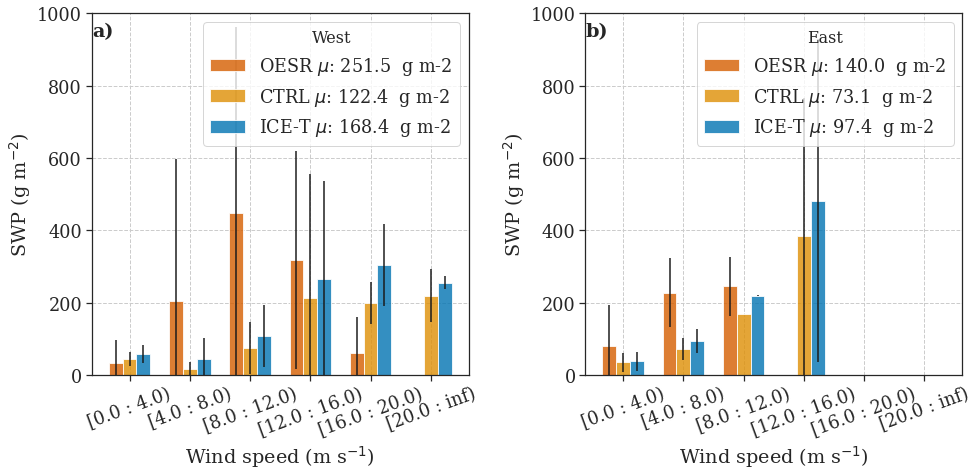

In [80]:
fig, axsm = plt.subplots(1, 2, figsize = [14,7])
axs = axsm.flatten()

plt_bar_obs_ret_meps(axs[0], ret['SWP_west_ws_mean'], ret['SWP_west_ws_std'], ret['SWC_west_hourly'], -1, 'OESR', sns.color_palette("colorblind",5)[3])
plt_bar_obs_ret_meps(axs[0], meps['CTRL']['SWP_west_ws_mean'], meps['CTRL']['SWP_west_ws_std'], meps['CTRL']['SWC_hourly_west'],0, 'CTRL', sns.color_palette("colorblind",5)[1])
plt_bar_obs_ret_meps(axs[0], meps['ICE-T']['SWP_west_ws_mean'], meps['ICE-T']['SWP_west_ws_std'],meps['ICE-T']['SWC_hourly_west'], 1, 'ICE-T', sns.color_palette("colorblind",5)[0])

# East
plt_bar_obs_ret_meps(axs[1], ret['SWP_east_ws_mean'], ret['SWP_east_ws_std'], ret['SWC_east_hourly'],-1, 'OESR', sns.color_palette("colorblind",5)[3])
plt_bar_obs_ret_meps(axs[1], meps['CTRL']['SWP_east_ws_mean'], meps['CTRL']['SWP_east_ws_std'], meps['CTRL']['SWC_hourly_east'], 0, 'CTRL', sns.color_palette("colorblind",5)[1])
plt_bar_obs_ret_meps(axs[1], meps['ICE-T']['SWP_east_ws_mean'], meps['ICE-T']['SWP_east_ws_std'], meps['ICE-T']['SWC_hourly_east'], 1, 'ICE-T', sns.color_palette("colorblind",5)[0])

for i, t in zip(range(len(axs)), ['West', 'East']):
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].set_ylim([0,1000])
#the legend is wrong you want to show the seasonal mean
    axs[i].legend(loc = 'best', 
              fancybox=True, facecolor ='white', title = t , title_fontsize=16)
    axs[i].set_ylabel('SWP (g m$^{-2}$)')
    
plt.tight_layout()

if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_SWP_WS_WD.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

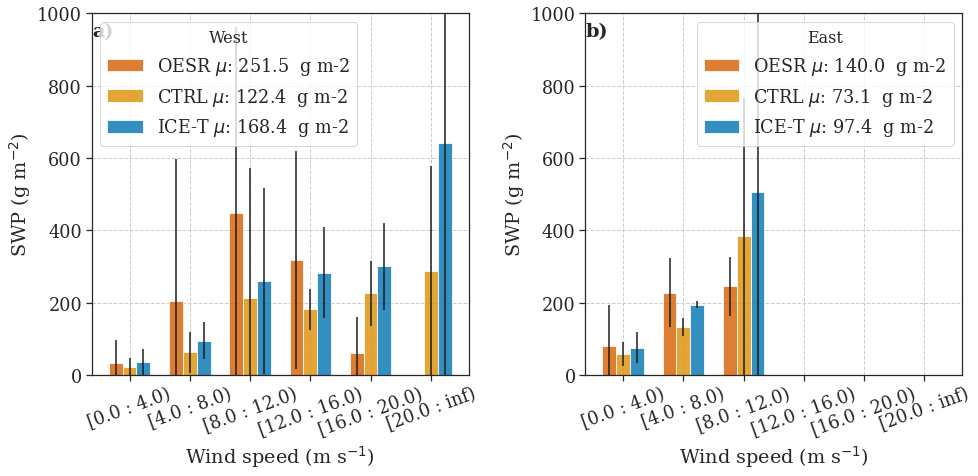

In [81]:
fig, axsm = plt.subplots(1, 2, figsize = [14,7])
axs = axsm.flatten()

plt_bar_obs_ret_meps(axs[0], ret['SWP_west_ws_mean'], ret['SWP_west_ws_std'], ret['SWC_west_hourly'], -1, 'OESR', sns.color_palette("colorblind",5)[3])
plt_bar_obs_ret_meps(axs[0], meps['CTRL']['SWP_west_ws_corre_mean'], meps['CTRL']['SWP_west_ws_corre_std'], meps['CTRL']['SWC_hourly_west'],0, 'CTRL', sns.color_palette("colorblind",5)[1])
plt_bar_obs_ret_meps(axs[0], meps['ICE-T']['SWP_west_ws_corre_mean'], meps['ICE-T']['SWP_west_ws_corre_std'],meps['ICE-T']['SWC_hourly_west'], 1, 'ICE-T', sns.color_palette("colorblind",5)[0])

# East
plt_bar_obs_ret_meps(axs[1], ret['SWP_east_ws_mean'], ret['SWP_east_ws_std'], ret['SWC_east_hourly'],-1, 'OESR', sns.color_palette("colorblind",5)[3])
plt_bar_obs_ret_meps(axs[1], meps['CTRL']['SWP_east_ws_corre_mean'], meps['CTRL']['SWP_east_ws_corre_std'], meps['CTRL']['SWC_hourly_east'], 0, 'CTRL', sns.color_palette("colorblind",5)[1])
plt_bar_obs_ret_meps(axs[1], meps['ICE-T']['SWP_east_ws_corre_mean'], meps['ICE-T']['SWP_east_ws_corre_std'], meps['ICE-T']['SWC_hourly_east'], 1, 'ICE-T', sns.color_palette("colorblind",5)[0])

for i, t in zip(range(len(axs)), ['West', 'East']):
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].set_ylim([0,1000])
#the legend is wrong you want to show the seasonal mean
    axs[i].legend(loc = 'best', 
              fancybox=True, facecolor ='white', title = t , title_fontsize=16)
    axs[i].set_ylabel('SWP (g m$^{-2}$)')
    
plt.tight_layout()

if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_SWP_WS_WD_correction.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()